# End-to-end Sequence Labeling via Bi-directional LSTM-CNNs-CRF

In this tutorial we will demonstrate how to implement a state of the art  Bi-directional LSTM-CNN-CRF architecture (Published at ACL'16. [Link To Paper](http://www.aclweb.org/anthology/P16-1101)) for Named Entity Recognition using Pytorch. 

The main aim of the tutorial is to make the audience comfortable with pytorch using this tutorial and give a step-by-step walk through of the Bi-LSTM-CNN-CRF architecture for NER. Some familiarity with pytorch (or any other deep learning framework) would definitely be a plus. 

The agenda of this tutorial is as follows:

1. Getting Ready with the data 
2. Network Definition. This includes
    * CNN Encoder for Character Level representation.
    * Bi-directional LSTM for Word-Level Encoding.
    * Conditional Random Fields(CRF) for output decoding
3. Training 
4. Model testing

This tutorial draws its content/design heavily from [this](https://github.com/ZhixiuYe/NER-pytorch) Github implementation of NER model. We reuse their data preprocessing/Model creation methodology. This helps in focussing more on explaining model architecture and it's translation from formulae to code. 

### Data Preparation

The paper uses the English data from CoNLL 2003 shared task\[1\], which is present in the "data" directory of this project. We will later apply more preprocessing steps to generate tag mapping, word mapping and character  mapping. The data set contains four different types of named entities: PERSON, LOCATION, ORGANIZATION, and MISC and uses the BIO tagging scheme

BIO tagging Scheme:

    I - Word is inside a phrase of type TYPE
    B - If two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE 
    O - Word is not part of a phrase
    
Example of English-NER sentence available in the data:
    
    U.N.         NNP  I-NP  I-ORG 
    official     NN   I-NP  O 
    Ekeus        NNP  I-NP  I-PER 
    heads        VBZ  I-VP  O 
    for          IN   I-PP  O 
    Baghdad      NNP  I-NP  I-LOC 
    .            .    O     O 
    
Data Split(We use the same split as mentioned in paper):

    Training Data - eng.train
    Validation Data - eng.testa
    Testing Data - eng.testb
    

 To get started we first import the necessary libraries

In [1]:
from __future__ import print_function
from collections import OrderedDict

import torch
import torch.nn as nn
from torch.nn import init
from torch.autograd import Variable
from torch import autograd

import time
import _pickle as cPickle

import os
import sys
import codecs
import re
import numpy as np

##### Define constants and paramaters

We now define some constants and parameters that we will be using later

In [2]:
#parameters for the Model
parameters = OrderedDict()
parameters['train'] = "./data/eng.train" #Path to train file
parameters['dev'] = "./data/eng.testa" #Path to test file
parameters['test'] = "./data/eng.testb" #Path to dev file
parameters['tag_scheme'] = "BIOES" #BIO or BIOES
parameters['lower'] = True # Boolean variable to control lowercasing of words
parameters['zeros'] =  True # Boolean variable to control replacement of  all digits by 0 
parameters['char_dim'] = 30 #Char embedding dimension
parameters['char_lstm_dim'] = 25 #Char LSTM hidden layer size
parameters['char_bidirect'] = True #Use a bidirectional LSTM for chars
parameters['word_dim'] = 100 #Token embedding dimension
parameters['word_lstm_dim'] = 200 #Token LSTM hidden layer size
parameters['word_bidirect'] = True #Use a bidirectional LSTM for words
parameters['embedding_path'] = "./data/glove.6B.100d.txt" #Location of pretrained embeddings
parameters['all_emb'] = 1 #Load all embeddings
parameters['cap_dim'] = 4 #Capitalization feature dimension (0 to disable)
parameters['crf'] =1 #Use CRF (0 to disable)
parameters['dropout'] = 0.5 #Droupout on the input (0 = no dropout)
parameters['epoch'] =  50 #Number of epochs to run"
parameters['weights'] = "" #path to Pretrained for from a previous run
parameters['reload'] = "" #Path to Reload the last saved model
parameters['name'] = "test" # Model name
parameters['char_mode'] = "CNN" #models for character Encoding

models_path = "./models" #path to saved models
eval_path = "./evaluation" # path to evaluation results and scripts

#GPU
parameters['use_gpu'] = torch.cuda.is_available() #GPU Check
use_gpu = parameters['use_gpu']

#Constants
START_TAG = '<START>'
STOP_TAG = '<STOP>'

In [3]:
#paths to files 
#To stored mapping file
mapping_file = './data/mapping.pkl'

#To stored model
name = parameters['name']
model_name = models_path + name #get_name(parameters)
tmp_model = model_name + '.tmp'

#To Evaluation Scripts
#We use the evaluation script provided for CONLL Shared Task
eval_temp = os.path.join(eval_path, "temp")
eval_script = os.path.join(eval_path, "conlleval")

if not os.path.isfile(eval_script):
    raise Exception('CoNLL evaluation script not found at "%s"' % eval_script)
if not os.path.exists(eval_temp):
    os.makedirs(eval_temp)
if not os.path.exists(models_path):
    os.makedirs(models_path)

##### load data and preprocess

Firstly, the data is loaded from the train, dev and test files into a list of sentences.

Preprocessing:

    * All the digits in the words are replaced by 0

In [4]:
def zero_digits(s):
    """
    Replace every digit in a string by a zero.
    """
    return re.sub('\d', '0', s)

def load_sentences(path, zeros):
    """
    Load sentences. A line must contain at least a word and its tag.
    Sentences are separated by empty lines.
    """
    sentences = []
    sentence = []
    for line in codecs.open(path, 'r', 'utf8'):
        line = zero_digits(line.rstrip()) if zeros else line.rstrip()
        if not line:
            if len(sentence) > 0:
                if 'DOCSTART' not in sentence[0][0]:
                    sentences.append(sentence)
                sentence = []
        else:
            word = line.split()
            assert len(word) >= 2
            sentence.append(word)
    if len(sentence) > 0:
        if 'DOCSTART' not in sentence[0][0]:
            sentences.append(sentence)
    return sentences

In [5]:
train_sentences = load_sentences(parameters['train'], parameters['zeros'])
test_sentences = load_sentences(parameters['test'], parameters['zeros'])
dev_sentences = load_sentences(parameters['dev'], parameters['zeros'])

##### Update tagging scheme

Different types of tagging schemes can be used for NER. We update the tags for train, test and dev data ( depending on the parameters \[ tag_scheme \] ).

In the paper, the authors use the tagging Scheme ( BIOES ) rather than BIO (which is used by the dataset). So, we need to first update the data to convert tag scheme from BIO to BIOES.

BIOES tagging scheme:

    I - Word is inside a phrase of type TYPE
    B - If two phrases of the same type immediately follow each other, the first word of the second phrase will have tag B-TYPE 
    O - Word is not part of a phrase
    E - End ( E will not appear in a prefix-only partial match )
    S - Single

In [6]:
def iob2(tags):
    """
    Check that tags have a valid BIO format.
    Tags in BIO1 format are converted to BIO2.
    """
    for i, tag in enumerate(tags):
        if tag == 'O':
            continue
        split = tag.split('-')
        if len(split) != 2 or split[0] not in ['I', 'B']:
            return False
        if split[0] == 'B':
            continue
        elif i == 0 or tags[i - 1] == 'O':  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
        elif tags[i - 1][1:] == tag[1:]:
            continue
        else:  # conversion IOB1 to IOB2
            tags[i] = 'B' + tag[1:]
    return True

def iob_iobes(tags):
    """
    BIO -> BIOES
    """
    new_tags = []
    for i, tag in enumerate(tags):
        if tag == 'O':
            new_tags.append(tag)
        elif tag.split('-')[0] == 'B':
            if i + 1 != len(tags) and \
               tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('B-', 'S-'))
        elif tag.split('-')[0] == 'I':
            if i + 1 < len(tags) and \
                    tags[i + 1].split('-')[0] == 'I':
                new_tags.append(tag)
            else:
                new_tags.append(tag.replace('I-', 'E-'))
        else:
            raise Exception('Invalid IOB format!')
    return new_tags

def update_tag_scheme(sentences, tag_scheme):
    """
    Check and update sentences tagging scheme to BIO2.
    Only BIO1 and BIO2 schemes are accepted for input data.
    """
    for i, s in enumerate(sentences):
        tags = [w[-1] for w in s]
        # Check that tags are given in the BIO format
        if not iob2(tags):
            s_str = '\n'.join(' '.join(w) for w in s)
            raise Exception('Sentences should be given in BIO format! ' +
                            'Please check sentence %i:\n%s' % (i, s_str))
        if tag_scheme == 'BIOES':
            new_tags = iob_iobes(tags)
            for word, new_tag in zip(s, new_tags):
                word[-1] = new_tag
        else:
            raise Exception('Wrong tagging scheme!')

In [7]:
update_tag_scheme(train_sentences, parameters['tag_scheme'])
update_tag_scheme(dev_sentences, parameters['tag_scheme'])
update_tag_scheme(test_sentences, parameters['tag_scheme'])

##### Create Mappings for Words, Characters and Tags

After we have updated the tag scheme. We now have a list of sentences which are words along with their modified tags. Now, we want to convert these individual words, tags and characters in each word, to unique numerical ID's so that each unique word, character and tag in the vocabulary is represented by a particular integer ID. To do this, we first create a functions that do these mapping for us

In [8]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    """
    words = [[x[0].lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

def char_mapping(sentences):
    """
    Create a dictionary and mapping of characters, sorted by frequency.
    """
    chars = ["".join([w[0] for w in s]) for s in sentences]
    dico = create_dico(chars)
    char_to_id, id_to_char = create_mapping(dico)
    print("Found %i unique characters" % len(dico))
    return dico, char_to_id, id_to_char

def tag_mapping(sentences):
    """
    Create a dictionary and a mapping of tags, sorted by frequency.
    """
    tags = [[word[-1] for word in s] for s in sentences]
    dico = create_dico(tags)
    dico[START_TAG] = -1
    dico[STOP_TAG] = -2
    tag_to_id, id_to_tag = create_mapping(dico)
    print("Found %i unique named entity tags" % len(dico))
    return dico, tag_to_id, id_to_tag

In [9]:
dico_words,word_to_id,id_to_word = word_mapping(train_sentences, parameters['lower'])
dico_chars, char_to_id, id_to_char = char_mapping(train_sentences)
dico_tags, tag_to_id, id_to_tag = tag_mapping(train_sentences)

Found 17493 unique words (203621 in total)
Found 75 unique characters
Found 19 unique named entity tags


##### Preparing final dataset

The function prepare dataset returns a list of dictionaries ( one dictionary per each sentence )

Each of the dictionary returned by the function contains
    1. list of all words in the sentence
    2. list of word index for all words in the sentence
    3. list of lists, containing character id of each character for words in the sentence
    4. list of Caps feature for words in the sentence (Usage of caps feature will be explained later in notebook)
    5. list of tag for each word in the sentence.

In [10]:
def cap_feature(s):
    """
    Capitalization feature:
    0 = low caps
    1 = all caps
    2 = first letter caps
    3 = one capital (not first letter)
    """
    if s.lower() == s:
        return 0
    elif s.upper() == s:
        return 1
    elif s[0].upper() == s[0]:
        return 2
    else:
        return 3

def prepare_dataset(sentences, word_to_id, char_to_id, tag_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - cap feature
        - tag indexes
    """
    def f(x): return x.lower() if lower else x
    data = []
    for s in sentences:
        str_words = [w[0] for w in s]
        words = [word_to_id[f(w) if f(w) in word_to_id else '<UNK>']
                 for w in str_words]
        # Skip characters that are not in the training set
        chars = [[char_to_id[c] for c in w if c in char_to_id]
                 for w in str_words]
        caps = [cap_feature(w) for w in str_words]
        tags = [tag_to_id[w[-1]] for w in s]
        data.append({
            'str_words': str_words,
            'words': words,
            'chars': chars,
            'caps': caps,
            'tags': tags,
        })
    return data

train_data = prepare_dataset(
    train_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
dev_data = prepare_dataset(
    dev_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
test_data = prepare_dataset(
    test_sentences, word_to_id, char_to_id, tag_to_id, parameters['lower']
)
print("{} / {} / {} sentences in train / dev / test.".format(len(train_data), len(dev_data), len(test_data)))

14041 / 3250 / 3453 sentences in train / dev / test.


We are  done with the preprocessing step for input data. It ready to be given as input to the model ! ! !

##### Load Word Embeddings

Now, We move to the next step of loading the pre-trained word embeddings.

The paper uses glove vectors 100 dimension vectors trained on the ( Wikipedia 2014 + Gigaword 5 ) corpus containing 6 Billion Words. The word embedding file ( glove.6B.100d.txt ) is placed in the data folder.

In [11]:
all_word_embeds = {}
for i, line in enumerate(codecs.open(parameters['embedding_path'], 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


##### Storing Processed Data for Reuse

We can store the preprocessed data and the embedding matrix for future reuse. This helps us avoid the time taken by the step of preprocessing, when we are trying to tune the hyper parameters for the model.

In [12]:
with open(mapping_file, 'wb') as f:
    mappings = {
        'word_to_id': word_to_id,
        'tag_to_id': tag_to_id,
        'char_to_id': char_to_id,
        'parameters': parameters,
        'word_embeds': word_embeds
    }
    cPickle.dump(mappings, f)

print('word_to_id: ', len(word_to_id))

word_to_id:  17493


### Model


The model that we are presenting is a complicated one, since its a hybridized network using LSTMs and CNNs. So in order to break down the complexity, we have attempted to simplify the process by splitting up operations into individual functions that we can go over part by part. This hopefully makes the whole thing more easily digestable and gives a more intuitive understanding of the whole process.

##### Initialization of weights

We start with the init_embedding function, which just initializes the embedding layer by pooling from a random sample. The distribution is pooled from $-\sqrt{\frac{3}{V}}$ to $+\sqrt{\frac{3}{V}}$ where $V$ is the embedding dimension size.

In [13]:
def init_embedding(input_embedding):
    """
    Initialize embedding
    """
    bias = np.sqrt(3.0 / input_embedding.size(1))
    nn.init.uniform(input_embedding, -bias, bias)

Similar to the initialization above, except this is for the linear layer.

In [14]:
def init_linear(input_linear):
    """
    Initialize linear transformation
    """
    bias = np.sqrt(6.0 / (input_linear.weight.size(0) + input_linear.weight.size(1)))
    nn.init.uniform(input_linear.weight, -bias, bias)
    if input_linear.bias is not None:
        input_linear.bias.data.zero_()

This is the initialization scheme for the LSTM layers. The LSTM layers are initialized by uniform sampling from $-\sqrt{\frac{6}{r+c}}$ to $+\sqrt{\frac{6}{r+c}}$. Where $r$ is the number of rows, $c$ is the number of columns (based on the shape of the weight matrix).

In [15]:
def init_lstm(input_lstm):
    """
    Initialize lstm
    
    
    PyTorch weights parameters:
    
        weight_ih_l[k]: the learnable input-hidden weights of the k-th layer,
            of shape `(hidden_size * input_size)` for `k = 0`. Otherwise, the shape is
            `(hidden_size * hidden_size)`
            
        weight_hh_l[k]: the learnable hidden-hidden weights of the k-th layer,
            of shape `(hidden_size * hidden_size)`
            
    
            
    """
    
    # Weights init for forward layer
    for ind in range(0, input_lstm.num_layers):
        
        ## Gets the weights Tensor from our model, for the input-hidden weights in our current layer
        weight = eval('input_lstm.weight_ih_l' + str(ind))
        
        # Initialize the sampling range
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        
        # Randomly sample from our samping range using uniform distribution and apply it to our current layer
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        # Similar to above but for the hidden-hidden weights of the current layer
        weight = eval('input_lstm.weight_hh_l' + str(ind))
        sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
        nn.init.uniform(weight, -sampling_range, sampling_range)
        
        
    # We do the above again, for the backward layer if we are using a bi-directional LSTM (our final model uses this)
    if input_lstm.bidirectional:
        for ind in range(0, input_lstm.num_layers):
            weight = eval('input_lstm.weight_ih_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)
            weight = eval('input_lstm.weight_hh_l' + str(ind) + '_reverse')
            sampling_range = np.sqrt(6.0 / (weight.size(0) / 4 + weight.size(1)))
            nn.init.uniform(weight, -sampling_range, sampling_range)

    # Bias initialization steps
    
    # We initialize them to zero except for the forget gate bias, which is initialized to 1
    if input_lstm.bias:
        for ind in range(0, input_lstm.num_layers):
            bias = eval('input_lstm.bias_ih_l' + str(ind))
            
            # Initializing to zero
            bias.data.zero_()
            
            # This is the range of indices for our forget gates for each LSTM cell
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
            #Similar for the hidden-hidden layer
            bias = eval('input_lstm.bias_hh_l' + str(ind))
            bias.data.zero_()
            bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
            
        # Similar to above, we do for backward layer if we are using a bi-directional LSTM 
        if input_lstm.bidirectional:
            for ind in range(0, input_lstm.num_layers):
                bias = eval('input_lstm.bias_ih_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1
                bias = eval('input_lstm.bias_hh_l' + str(ind) + '_reverse')
                bias.data.zero_()
                bias.data[input_lstm.hidden_size: 2 * input_lstm.hidden_size] = 1

##### Helper function to calculate scores

This is a score function for our sentences. This function takes two things, a list of ground truths that tell us what the corresponding tags are, the other are the features which contains the supposed tagged parts of the function. Which is then used to compute the score.

In [16]:
def score_sentences(self, feats, tags):
    # tags is ground_truth, a list of ints, length is len(sentence)
    # feats is a 2D tensor, len(sentence) * tagset_size
    r = torch.LongTensor(range(feats.size()[0]))
    if self.use_gpu:
        r = r.cuda()
        pad_start_tags = torch.cat([torch.cuda.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.cuda.LongTensor([self.tag_to_ix[STOP_TAG]])])
    else:
        pad_start_tags = torch.cat([torch.LongTensor([self.tag_to_ix[START_TAG]]), tags])
        pad_stop_tags = torch.cat([tags, torch.LongTensor([self.tag_to_ix[STOP_TAG]])])

    score = torch.sum(self.transitions[pad_stop_tags, pad_start_tags]) + torch.sum(feats[r, tags])

    return score

This function returns the LSTM's tagged features. It takes in characters, converts them to embeddings using our character CNN, then we use this as features that we feed to LSTM. The LSTM makes predictions based on these set of features and then we pass over the resulting output to our sentence_score function to calculate the quality of our predictions

In [17]:
def get_lstm_features(self, sentence, chars2, caps, chars2_length, d):
    chars_embeds = self.char_embeds(chars2).unsqueeze(1)
    chars_cnn_out3 = self.char_cnn3(chars_embeds)
    chars_embeds = nn.functional.max_pool2d(chars_cnn_out3,
                                         kernel_size=(chars_cnn_out3.size(2), 1)).view(chars_cnn_out3.size(0), self.out_channels)

    # t = self.hw_gate(chars_embeds)
    # g = nn.functional.sigmoid(t)
    # h = nn.functional.relu(self.hw_trans(chars_embeds))
    # chars_embeds = g * h + (1 - g) * chars_embeds

    embeds = self.word_embeds(sentence)
    if self.n_cap and self.cap_embedding_dim:
        cap_embedding = self.cap_embeds(caps)

    if self.n_cap and self.cap_embedding_dim:
        embeds = torch.cat((embeds, chars_embeds, cap_embedding), 1)
    else:
        embeds = torch.cat((embeds, chars_embeds), 1)

    embeds = embeds.unsqueeze(1)
    embeds = self.dropout(embeds)
    lstm_out, _ = self.lstm(embeds)
    lstm_out = lstm_out.view(len(sentence), self.hidden_dim*2)
    lstm_out = self.dropout(lstm_out)
    lstm_feats = self.hidden2tag(lstm_out)
    return lstm_feats

##### CRF Layer

We have two options: 

* softmax: normalize the scores into a vector such that can be interpreted as the probability that the word belongs to class. Eventually, the probability of a sequence of tag $y$ is the product of all tags.


* linear-chain CRF: the first method makes local choices. In other words, even if we capture some information from the context thanks to the bi-LSTM, the tagging decision is still local. We don’t make use of the neighbooring tagging decisions. Given a sequence of words $w_1,…,w_m$, a sequence of score vectors $s_1,…,s_m$ and a sequence of tags $y_1,…,y_m$, a linear-chain CRF defines a global score $C \in \mathbb{R}$ such that

$$% <![CDATA[
\begin{align*}
C(y_1, \ldots, y_m) &= b[y_1] &+ \sum_{t=1}^{m} s_t [y_t] &+ \sum_{t=1}^{m-1} T[y_{t}, y_{t+1}] &+ e[y_m]\\
                    &= \text{begin} &+ \text{scores} &+ \text{transitions} &+ \text{end}
\end{align*} %]]>$$

where $T$ is a transition matrix in $R^{9×9}$ and $e,b \in R^9$ are vectors of scores that capture the cost of beginning or ending with a given tag. The use of the matrix $T$ captures linear (one step) dependencies between tagging decisions.

The motivation behind CRFs was to generate sentence level likelihoods for optimal tags. What that means is for each word we estimate maximum likelihood and then we use the Viterbi algorithm to decode the tag sequence optimally.


Advantages of CRF over Softmax:
* Softmax doesn't value any dependencies, this is a problem since NER the context heavily influences the tag that is assigned. This is solved by applying CRF as it takes into account the full sequence to assign the tag. 
* *Example: I-ORG cannot directly follow I-PER.*

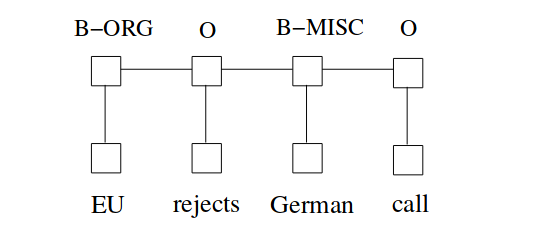

The figure shows a simple CRF network, in our case we have the inputs feeding in from our BiLSTMs, but otherwise the structure largely remains the same.

##### Evaluation schemes: Forward pass and Viterbi algorithm

Recall that the CRF computes a conditional probability. Let $y$ be a tag sequence and $x$ an input sequence of words. Then we compute

$$P(y|x) = \frac{\exp{(\text{Score}(x, y)})}{\sum_{y'} \exp{(\text{Score}(x, y')})}$$

Where the score is determined by defining some log potentials $\log \psi_i(x,y)$ such that

$$\text{Score}(x,y) = \sum_i \log \psi_i(x,y)$$

In our model, we define two kinds of potentials: emission and transition. The emission potential for the word at index $i$ comes from the hidden state of the Bi-LSTM at timestep $i$. The transition scores are stored in a $|T|x|T|$ matrix $P$, where $T$ is the tag set. In my implementation, $P_{j,k}$ is the score of transitioning to tag $j$ from tag $k$. So:

$$\text{Score}(x,y) = \sum_i \log \psi_\text{EMIT}(y_i \rightarrow x_i) + \log \psi_\text{TRANS}(y_{i-1} \rightarrow y_i)$$
$$= \sum_i h_i[y_i] + \textbf{P}_{y_i, y_{i-1}}$$

In [18]:
def forward_alg(self, feats):
    # calculate in log domain
    # feats is len(sentence) * tagset_size
    # initialize alpha with a Tensor with values all equal to -10000.
    
    # Do the forward algorithm to compute the partition function
    init_alphas = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    
    # START_TAG has all of the score.
    init_alphas[0][self.tag_to_ix[START_TAG]] = 0.
    
    # Wrap in a variable so that we will get automatic backprop
    forward_var = autograd.Variable(init_alphas)
    if self.use_gpu:
        forward_var = forward_var.cuda()
        
    # Iterate through the sentence
    for feat in feats:
        # broadcast the emission score: it is the same regardless of
        # the previous tag
        emit_score = feat.view(-1, 1)
        
        # the ith entry of trans_score is the score of transitioning to
        # next_tag from i
        tag_var = forward_var + self.transitions + emit_score
        
        # The ith entry of next_tag_var is the value for the
        # edge (i -> next_tag) before we do log-sum-exp
        max_tag_var, _ = torch.max(tag_var, dim=1)
        
        # The forward variable for this tag is log-sum-exp of all the
        # scores.
        tag_var = tag_var - max_tag_var.view(-1, 1)
        
        # Compute log sum exp in a numerically stable way for the forward algorithm
        forward_var = max_tag_var + torch.log(torch.sum(torch.exp(tag_var), dim=1)).view(1, -1) # ).view(1, -1)
    terminal_var = (forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]).view(1, -1)
    alpha = log_sum_exp(terminal_var)
    # Z(x)
    return alpha

Viterbi decode is basically applying dynamic programming to choosing our tag sequence. Let’s suppose that we have the solution $\tilde{s}_{t+1} (y^{t+1})$ for time steps $t + 1, ...., m$ for sequences that start with $y^{t+1}$ for each of the possible $y^{t+1}$. Then the solution $\tilde{s}_t(y_t)$ for time steps $t, ..., m$ that starts with $y_t$ verifies 

$$ % <![CDATA[
\begin{align*}
\tilde{s}_t(y_t) &= \operatorname{argmax}_{y_t, \ldots, y_m} C(y_t, \ldots, y_m)\\
            &= \operatorname{argmax}_{y_{t+1}} s_t [y_t] + T[y_{t}, y_{t+1}] + \tilde{s}_{t+1}(y^{t+1})
\end{align*} %]]>$$

Then, we can easily define the probability of a given sequence of tags as

$$ \mathbb{P}(y_1, \ldots, y_m) = \frac{e^{C(y_1, \ldots, y_m)}}{Z} $$

In [19]:
def viterbi_algo(self, feats):
    backpointers = []
    # analogous to forward
    
    # Initialize the viterbi variables in log space
    init_vvars = torch.Tensor(1, self.tagset_size).fill_(-10000.)
    init_vvars[0][self.tag_to_ix[START_TAG]] = 0
    
    # forward_var at step i holds the viterbi variables for step i-1
    forward_var = Variable(init_vvars)
    if self.use_gpu:
        forward_var = forward_var.cuda()
    for feat in feats:
        next_tag_var = forward_var.view(1, -1).expand(self.tagset_size, self.tagset_size) + self.transitions
        _, bptrs_t = torch.max(next_tag_var, dim=1)
        bptrs_t = bptrs_t.squeeze().data.cpu().numpy() # holds the backpointers for this step
        next_tag_var = next_tag_var.data.cpu().numpy() 
        viterbivars_t = next_tag_var[range(len(bptrs_t)), bptrs_t] # holds the viterbi variables for this step
        viterbivars_t = Variable(torch.FloatTensor(viterbivars_t))
        if self.use_gpu:
            viterbivars_t = viterbivars_t.cuda()
            
        # Now add in the emission scores, and assign forward_var to the set
        # of viterbi variables we just computed
        forward_var = viterbivars_t + feat
        backpointers.append(bptrs_t)

    # Transition to STOP_TAG
    terminal_var = forward_var + self.transitions[self.tag_to_ix[STOP_TAG]]
    terminal_var.data[self.tag_to_ix[STOP_TAG]] = -10000.
    terminal_var.data[self.tag_to_ix[START_TAG]] = -10000.
    best_tag_id = argmax(terminal_var.unsqueeze(0))
    path_score = terminal_var[best_tag_id]
    
    # Follow the back pointers to decode the best path.
    best_path = [best_tag_id]
    for bptrs_t in reversed(backpointers):
        best_tag_id = bptrs_t[best_tag_id]
        best_path.append(best_tag_id)
        
    # Pop off the start tag (we dont want to return that to the caller)
    start = best_path.pop()
    assert start == self.tag_to_ix[START_TAG] # Sanity check
    best_path.reverse()
    return path_score, best_path

This is a helper function that calculates the negative log likelihood. This is where we put our previously generated LSTM features to use to calculate the sentence score and then perform a forward run score and compare it with our predicted score to generate a log likelihood. 

`Implementation detail: Notice we do not pump out any log conversion in this function that is supposedly about log likelihood calculation, this is because we have ensured that we get the scores from our helper functions in the log domain.`

In [20]:
def get_neg_log_likelihood(self, sentence, tags, chars2, caps, chars2_length, d):
    # sentence, tags is a list of ints
    # features is a 2D tensor, len(sentence) * self.tagset_size
    feats = self._get_lstm_features(sentence, chars2, caps, chars2_length, d)

    if self.use_crf:
        forward_score = self._forward_alg(feats)
        gold_score = self._score_sentence(feats, tags)
        return forward_score - gold_score
    else:
        tags = Variable(tags)
        scores = nn.functional.cross_entropy(feats, tags)
        return scores

The standard forward algorithm that we went over in class *PLACEHOLDER: put blurb explaining the details of forward algo from the book*

In [21]:
def forward_calc(self, sentence, chars, caps, chars2_length, d):
    
    # Get the emission scores from the BiLSTM
    feats = self._get_lstm_features(sentence, chars, caps, chars2_length, d)
    # viterbi to get tag_seq
    
    # Find the best path, given the features.
    if self.use_crf:
        score, tag_seq = self.viterbi_decode(feats)
    else:
        score, tag_seq = torch.max(feats, 1)
        tag_seq = list(tag_seq.cpu().data)

    return score, tag_seq

##### Final Model Details

##### 1. CNN model for generating character embeddings


Consider the word 'cat', we pad it on both ends to get our maximum word length ( this is mainly an implementation quirk since we can't have variable length layers at run time, our algorithm will ignore the pads).

We then apply a convolution layer on top that generates spatial coherence across characters, we use a maxpool to extract meaningful features out of our convolution layer. This now gives us a dense vector representation of each word. This representation will be concatenated with the pre-trained GloVe embeddings using a simple lookup.


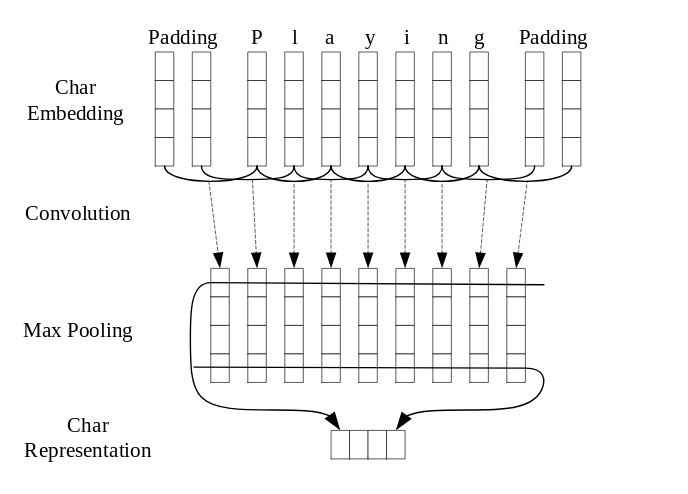


This snippet shows us how the CNN is implemented

`self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))`

##### 2. Rest of the model (LSTM based) that generates tags for the given sequence

The word-embeddings that we generated above, we feed to a bi-directional LSTM model. The LSTM model has 2 layers, 
* The forward layer takes in a sequence of word vectors and generates a new vector based on what it has seen so far in the forward direction (starting from the start word up until current word) this vector can be thought of as a summary of all the words it has seen. 

* The backwards layer does the same but in opposite direction, i.e., from the end of the sentence to the current word.

The forward vector and the backwards vector at current word concatanate to generate a unified representation.

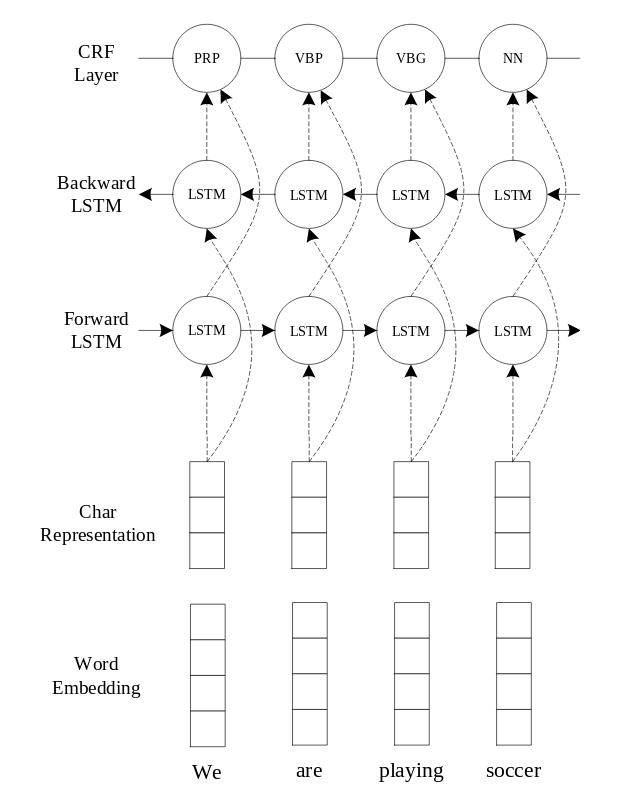

This snippet shows us how the BiLSTM is implemented

`self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)`

In [22]:
class BiLSTM_CRF(nn.Module):

    def __init__(self, vocab_size, tag_to_ix, embedding_dim, hidden_dim, char_lstm_dim=25,
                 char_to_ix=None, pre_word_embeds=None, char_embedding_dim=25, use_gpu=False,
                 n_cap=None, cap_embedding_dim=None, use_crf=True, char_mode='CNN'):
        super(BiLSTM_CRF, self).__init__()
        self.use_gpu = use_gpu
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.vocab_size = vocab_size
        self.tag_to_ix = tag_to_ix
        self.n_cap = n_cap
        self.cap_embedding_dim = cap_embedding_dim
        self.use_crf = use_crf
        self.tagset_size = len(tag_to_ix)
        self.out_channels = char_lstm_dim
        self.char_mode = char_mode

        print('char_mode: %s, out_channels: %d, hidden_dim: %d, ' % (char_mode, char_lstm_dim, hidden_dim))

        if self.n_cap and self.cap_embedding_dim:
            self.cap_embeds = nn.Embedding(self.n_cap, self.cap_embedding_dim)
            init_embedding(self.cap_embeds.weight)

        if char_embedding_dim is not None:
            self.char_lstm_dim = char_lstm_dim
            self.char_embeds = nn.Embedding(len(char_to_ix), char_embedding_dim)
            init_embedding(self.char_embeds.weight)
            self.char_cnn3 = nn.Conv2d(in_channels=1, out_channels=self.out_channels, kernel_size=(3, char_embedding_dim), padding=(2,0))

        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        if pre_word_embeds is not None:
            self.pre_word_embeds = True
            self.word_embeds.weight = nn.Parameter(torch.FloatTensor(pre_word_embeds))
        else:
            self.pre_word_embeds = False

        self.dropout = nn.Dropout(0.5)
        if self.n_cap and self.cap_embedding_dim:
                self.lstm = nn.LSTM(embedding_dim+self.out_channels+cap_embedding_dim, hidden_dim, bidirectional=True)
        else:
                self.lstm = nn.LSTM(embedding_dim+self.out_channels, hidden_dim, bidirectional=True)
        init_lstm(self.lstm)
        self.hw_trans = nn.Linear(self.out_channels, self.out_channels)
        self.hw_gate = nn.Linear(self.out_channels, self.out_channels)
        self.h2_h1 = nn.Linear(hidden_dim*2, hidden_dim)
        self.tanh = nn.Tanh()
        
        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim*2, self.tagset_size)
        init_linear(self.h2_h1)
        init_linear(self.hidden2tag)
        init_linear(self.hw_gate)
        init_linear(self.hw_trans)

        if self.use_crf:
            # Matrix of transition parameters.  Entry i,j is the score of
            # transitioning *to* i *from* j.
            self.transitions = nn.Parameter(
                torch.zeros(self.tagset_size, self.tagset_size))
            
            # These two statements enforce the constraint that we never transfer
            # to the start tag and we never transfer from the stop tag
            self.transitions.data[tag_to_ix[START_TAG], :] = -10000
            self.transitions.data[:, tag_to_ix[STOP_TAG]] = -10000

    _score_sentence = score_sentences
    _get_lstm_features = get_lstm_features
    _forward_alg = forward_alg
    viterbi_decode = viterbi_algo
    neg_log_likelihood = get_neg_log_likelihood
    forward = forward_calc

In [23]:
model = BiLSTM_CRF(vocab_size=len(word_to_id),
                   tag_to_ix=tag_to_id,
                   embedding_dim=parameters['word_dim'],
                   hidden_dim=parameters['word_lstm_dim'],
                   use_gpu=use_gpu,
                   char_to_ix=char_to_id,
                   pre_word_embeds=word_embeds,
                   use_crf=parameters['crf'],
                   char_mode='CNN')

char_mode: CNN, out_channels: 25, hidden_dim: 200, 


In [24]:
if parameters['reload']:
    model.load_state_dict(torch.load(model_name))
if use_gpu:
    model.cuda()

### Train Paramaters

In [25]:
learning_rate = 0.015
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

losses = []
loss = 0.0
best_dev_F = -1.0
best_test_F = -1.0
best_train_F = -1.0
all_F = [[0, 0, 0]]
plot_every = 10
eval_every = 20
count = 0

## Evaluation

In [26]:
def evaluating(model, datas, best_F):
    prediction = []
    save = False
    new_F = 0.0
    confusion_matrix = torch.zeros((len(tag_to_id) - 2, len(tag_to_id) - 2))
    for data in datas:
        ground_truth_id = data['tags']
        words = data['str_words']
        chars2 = data['chars']
        caps = data['caps']

        d = {}
        chars2_length = [len(c) for c in chars2]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
        for i, c in enumerate(chars2):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))

        dwords = Variable(torch.LongTensor(data['words']))
        dcaps = Variable(torch.LongTensor(caps))
        if use_gpu:
            val, out = model(dwords.cuda(), chars2_mask.cuda(), dcaps.cuda(), chars2_length, d)
        else:
            val, out = model(dwords, chars2_mask, dcaps, chars2_length, d)
        predicted_id = out
        
        for (word, true_id, pred_id) in zip(words, ground_truth_id, predicted_id):
            line = ' '.join([word, id_to_tag[true_id], id_to_tag[pred_id]])
            prediction.append(line)
            confusion_matrix[true_id, pred_id] += 1
        prediction.append('')
        
    predf = eval_temp + '/pred.' + name
    scoref = eval_temp + '/score.' + name

    with open(predf, 'w') as f:
        f.write('\n'.join(prediction))

    os.system('%s < %s > %s' % (eval_script, predf, scoref))

    eval_lines = [l.rstrip() for l in codecs.open(scoref, 'r', 'utf8')]

    for i, line in enumerate(eval_lines):
        print(line)
        if i == 1:
            new_F = float(line.strip().split()[-1])
            if new_F > best_F:
                best_F = new_F
                save = True
                print('the best F is ', new_F)

    print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
        "ID", "NE", "Total",
        *([id_to_tag[i] for i in range(confusion_matrix.size(0))] + ["Percent"])
    ))
    for i in range(confusion_matrix.size(0)):
        print(("{: >2}{: >7}{: >7}%s{: >9}" % ("{: >7}" * confusion_matrix.size(0))).format(
            str(i), id_to_tag[i], str(confusion_matrix[i].sum()),
            *([confusion_matrix[i][j] for j in range(confusion_matrix.size(0))] +
              ["%.3f" % (confusion_matrix[i][i] * 100. / max(1, confusion_matrix[i].sum()))])
        ))
    return best_F, new_F, save

## Model train

In [ ]:
def log_sum_exp(vec):
    # vec 2D: 1 * tagset_size
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))
    
def argmax(vec):
    _, idx = torch.max(vec, 1)
    return to_scalar(idx)

def to_scalar(var):
    return var.view(-1).data.tolist()[0]

In [ ]:
model.train(True)
for epoch in range(1, 10001):
    for i, index in enumerate(np.random.permutation(len(train_data))):
        tr = time.time()
        count += 1
        data = train_data[index]
        model.zero_grad()

        sentence_in = data['words']
        sentence_in = Variable(torch.LongTensor(sentence_in))
        tags = data['tags']
        chars2 = data['chars']

        # ######## char cnn
        d = {}
        chars2_length = [len(c) for c in chars2]
        char_maxl = max(chars2_length)
        chars2_mask = np.zeros((len(chars2_length), char_maxl), dtype='int')
        for i, c in enumerate(chars2):
            chars2_mask[i, :chars2_length[i]] = c
        chars2_mask = Variable(torch.LongTensor(chars2_mask))


        targets = torch.LongTensor(tags)
        caps = Variable(torch.LongTensor(data['caps']))
        if use_gpu:
            neg_log_likelihood = model.neg_log_likelihood(sentence_in.cuda(), targets.cuda(), chars2_mask.cuda(), caps.cuda(), chars2_length, d)
        else:
            neg_log_likelihood = model.neg_log_likelihood(sentence_in, targets, chars2_mask, caps, chars2_length, d)
        loss += neg_log_likelihood.data[0] / len(data['words'])
        neg_log_likelihood.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 5.0)
        optimizer.step()

        if count % plot_every == 0:
            loss /= plot_every
            print(count, ': ', loss)
            if losses == []:
                losses.append(loss)
            losses.append(loss)
            text = '<p>' + '</p><p>'.join([str(l) for l in losses[-9:]]) + '</p>'
            losswin = 'loss_' + name
            textwin = 'loss_text_' + name
            loss = 0.0

        if count % (eval_every) == 0 and count > (eval_every * 20) or \
                count % (eval_every*4) == 0 and count < (eval_every * 20):
            model.train(False)
            best_train_F, new_train_F, _ = evaluating(model, train_data, best_train_F)
            best_dev_F, new_dev_F, save = evaluating(model, dev_data, best_dev_F)
            if save:
                torch.save(model, model_name)
            best_test_F, new_test_F, _ = evaluating(model, test_data, best_test_F)
            sys.stdout.flush()

            all_F.append([new_train_F, new_dev_F, new_test_F])
            Fwin = 'F-score of {train, dev, test}_' + name
            model.train(True)

        if count % len(train_data) == 0:
            adjust_learning_rate(optimizer, lr=learning_rate/(1+0.05*count/len(train_data)))


print(time.time() - t)

10 :  1.499085731807561
20 :  1.3913217791732477
30 :  1.327386808963049
40 :  0.909283734429151
50 :  0.8091380529328305
60 :  0.6516989747925799
70 :  1.3303987728204942
80 :  1.023445614847842
processed 203621 tokens with 23429 phrases; found: 2010 phrases; correct: 1257.
accuracy:  83.73%; precision:  62.54%; recall:   5.37%; FB1:   9.88
the best F is  9.88
              LOC: precision:  33.21%; recall:   3.73%; FB1:   6.71  801
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              ORG: precision:  82.02%; recall:  15.72%; FB1:  26.39  1207
              PER: precision:  50.00%; recall:   0.02%; FB1:   0.03  2
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O169578.0169510.0   36.0    0.0    0.0   32.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.960
 1  S-LOC 6099.0 5828.0  264.0    0.0    0.0    7.0    

/usr/lib/python3.6/site-packages/torch/serialization.py:159: UserWarning: Couldn't retrieve source code for container of type BiLSTM_CRF. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


processed 46435 tokens with 5628 phrases; found: 406 phrases; correct: 309.
accuracy:  83.05%; precision:  76.11%; recall:   5.49%; FB1:  10.24
the best F is  10.24
              LOC: precision:  53.33%; recall:   1.93%; FB1:   3.72  60
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              ORG: precision:  80.99%; recall:  16.73%; FB1:  27.73  342
              PER: precision:   0.00%; recall:   0.00%; FB1:   0.00  4
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038305.0    3.0    2.0    4.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.953
 1  S-LOC 1436.0 1402.0   32.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    2.228
 2  B-PER 1086.0 1072.0   14.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 557 phrases; correct: 327.
accuracy:  83.30%; precision:  58.71%; recall:   5.81%; FB1:  10.57
the best F is  10.57
              LOC: precision:  69.48%; recall:   8.90%; FB1:  15.79  213
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              ORG: precision:  89.83%; recall:   3.20%; FB1:   6.18  59
              PER: precision:  44.21%; recall:   7.79%; FB1:  13.25  285
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038269.0    5.0   45.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.859
 1  S-LOC 1436.0 1285.0  148.0    1.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   10.306
 2  B-PER 1086.0  920.0   11.0  107.0   46.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 1719 phrases; correct: 1107.
accuracy:  85.51%; precision:  64.40%; recall:  19.67%; FB1:  30.13
the best F is  30.13
              LOC: precision:  42.23%; recall:  18.95%; FB1:  26.16  746
             MISC: precision:   0.00%; recall:   0.00%; FB1:   0.00  0
              ORG: precision:  88.17%; recall:  18.90%; FB1:  31.13  355
              PER: precision:  77.51%; recall:  29.62%; FB1:  42.86  618
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038183.0   71.0   42.0   17.0    1.0    0.0    0.0    3.0    6.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.635
 1  S-LOC 1436.0 1119.0  312.0    3.0    0.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   21.727
 2  B-PER 1086.0  588.0   17.0  462.0   17.0    0.0    0.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0 

processed 46435 tokens with 5628 phrases; found: 2462 phrases; correct: 1592.
accuracy:  86.30%; precision:  64.66%; recall:  28.29%; FB1:  39.36
the best F is  39.36
              LOC: precision:  74.19%; recall:  19.19%; FB1:  30.50  430
             MISC: precision:  45.65%; recall:  12.12%; FB1:  19.16  184
              ORG: precision:  70.33%; recall:  35.51%; FB1:  47.19  836
              PER: precision:  59.39%; recall:  37.17%; FB1:  45.72  1012
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037946.0   15.0  175.0  134.0   22.0   31.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.016
 1  S-LOC 1436.0  993.0  315.0   12.0   12.0   64.0   39.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   21.936
 2  B-PER 1086.0  383.0    6.0  619.0   62.0   16.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 3533 phrases; correct: 2382.
accuracy:  88.48%; precision:  67.42%; recall:  42.32%; FB1:  52.00
the best F is  52.0
              LOC: precision:  68.51%; recall:  51.56%; FB1:  58.84  1251
             MISC: precision:  44.04%; recall:  38.38%; FB1:  41.02  604
              ORG: precision:  83.91%; recall:  32.43%; FB1:  46.78  640
              PER: precision:  69.56%; recall:  44.65%; FB1:  54.39  1038
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037929.0   93.0   96.0   72.0    1.0  121.0    0.0    3.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   98.972
 1  S-LOC 1436.0  483.0  848.0   11.0    2.0   16.0   73.0    0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   59.053
 2  B-PER 1086.0  335.0   10.0  696.0   39.0    2.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 3487 phrases; correct: 2273.
accuracy:  87.75%; precision:  65.18%; recall:  40.39%; FB1:  49.87
              LOC: precision:  61.02%; recall:  55.48%; FB1:  58.12  1511
             MISC: precision:  94.34%; recall:   7.22%; FB1:  13.40  53
              ORG: precision:  65.93%; recall:  41.36%; FB1:  50.83  1039
              PER: precision:  69.68%; recall:  38.10%; FB1:  49.26  884
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037999.0  132.0   65.0   43.0   46.0    0.0    0.0    0.0   38.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.155
 1  S-LOC 1436.0  472.0  911.0    3.0    0.0   45.0    0.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   63.440
 2  B-PER 1086.0  406.0   20.0  571.0   33.0   28.0    0.0    0.0    0.0   28.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 1650 phrases; correct: 1144.
accuracy:  85.46%; precision:  69.33%; recall:  20.33%; FB1:  31.44
              LOC: precision:  70.26%; recall:  27.86%; FB1:  39.90  659
             MISC: precision:  67.95%; recall:  15.30%; FB1:  24.97  156
              ORG: precision:  84.14%; recall:  23.07%; FB1:  36.21  454
              PER: precision:  50.66%; recall:  11.94%; FB1:  19.32  381
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038274.0   26.0    6.0    3.0    0.0    8.0    0.0    1.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.872
 1  S-LOC 1436.0  958.0  457.0    0.0    0.0   12.0    7.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   31.825
 2  B-PER 1086.0  823.0   16.0  134.0    2.0    0.0   12.0    0.0    0.0   99.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 2130 phrases; correct: 1654.
accuracy:  87.26%; precision:  77.65%; recall:  29.39%; FB1:  42.64
              LOC: precision:  74.90%; recall:  33.57%; FB1:  46.36  745
             MISC: precision:  88.46%; recall:   3.32%; FB1:   6.40  26
              ORG: precision:  81.42%; recall:  37.32%; FB1:  51.18  759
              PER: precision:  75.83%; recall:  28.14%; FB1:  41.05  600
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038217.0   33.0   29.0   32.0    3.0    0.0    0.0    7.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.723
 1  S-LOC 1436.0  827.0  553.0    6.0    0.0   44.0    0.0    4.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   38.510
 2  B-PER 1086.0  617.0    8.0  434.0   20.0    0.0    0.0    2.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

processed 46435 tokens with 5628 phrases; found: 2061 phrases; correct: 1502.
accuracy:  86.51%; precision:  72.88%; recall:  26.69%; FB1:  39.07
              LOC: precision:  66.75%; recall:  46.51%; FB1:  54.82  1158
             MISC: precision:  42.86%; recall:   2.16%; FB1:   4.12  35
              ORG: precision:  83.96%; recall:  28.44%; FB1:  42.49  561
              PER: precision:  79.15%; recall:  15.03%; FB1:  25.26  307
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038257.0   44.0    6.0    2.0    2.0    0.0    0.0    2.0    0.0    0.0    0.0    0.0    1.0    9.0    0.0    0.0    0.0   99.828
 1  S-LOC 1436.0  654.0  760.0    2.0    0.0   16.0    0.0    1.0    2.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   52.925
 2  B-PER 1086.0  815.0   32.0  219.0    1.0    0.0    0.0    1.0    0.0   18.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 1402 phrases; correct: 1176.
accuracy:  86.06%; precision:  83.88%; recall:  20.90%; FB1:  33.46
              LOC: precision:  87.43%; recall:  17.99%; FB1:  29.84  342
             MISC: precision:  92.86%; recall:   1.88%; FB1:   3.68  14
              ORG: precision:  81.69%; recall:  30.98%; FB1:  44.92  628
              PER: precision:  83.97%; recall:  21.71%; FB1:  34.50  418
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038273.0   15.0   12.0   12.0    4.0    0.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.870
 1  S-LOC 1436.0 1099.0  295.0    6.0    1.0   21.0    0.0   13.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   20.543
 2  B-PER 1086.0  724.0    0.0  358.0    3.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

processed 46435 tokens with 5628 phrases; found: 2696 phrases; correct: 2030.
accuracy:  87.81%; precision:  75.30%; recall:  36.07%; FB1:  48.77
              LOC: precision:  83.63%; recall:  25.21%; FB1:  38.74  501
             MISC: precision:  62.20%; recall:  34.20%; FB1:  44.13  381
              ORG: precision:  73.55%; recall:  42.15%; FB1:  53.59  949
              PER: precision:  78.15%; recall:  41.81%; FB1:  54.47  865
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038155.0   22.0   37.0   33.0   30.0   28.0    0.0    8.0   10.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.562
 1  S-LOC 1436.0  878.0  412.0    6.0    0.0   79.0   48.0    9.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   28.691
 2  B-PER 1086.0  414.0    0.0  646.0   10.0    8.0    1.0    0.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 2379 phrases; correct: 1850.
accuracy:  87.91%; precision:  77.76%; recall:  32.87%; FB1:  46.21
              LOC: precision:  79.33%; recall:  28.40%; FB1:  41.83  595
             MISC: precision:  91.30%; recall:   3.03%; FB1:   5.87  23
              ORG: precision:  78.97%; recall:  37.86%; FB1:  51.18  794
              PER: precision:  75.49%; recall:  45.15%; FB1:  56.50  967
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038156.0   27.0   76.0   48.0   11.0    0.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.564
 1  S-LOC 1436.0  914.0  468.0    8.0    2.0   36.0    0.0    6.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   32.591
 2  B-PER 1086.0  323.0    0.0  742.0   18.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

processed 46435 tokens with 5628 phrases; found: 2930 phrases; correct: 2256.
accuracy:  88.87%; precision:  77.00%; recall:  40.09%; FB1:  52.72
the best F is  52.72
              LOC: precision:  78.31%; recall:  44.10%; FB1:  56.43  936
             MISC: precision:  90.91%; recall:   4.33%; FB1:   8.26  33
              ORG: precision:  78.23%; recall:  41.67%; FB1:  54.37  882
              PER: precision:  74.42%; recall:  49.66%; FB1:  59.57  1079
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038078.0   31.0   99.0   84.0    9.0    0.0    7.0   15.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.361
 1  S-LOC 1436.0  641.0  725.0   12.0    2.0   39.0    0.0   16.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   50.487
 2  B-PER 1086.0  237.0    0.0  823.0   19.0    2.0    0.0    5.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 3528 phrases; correct: 2318.
accuracy:  88.40%; precision:  65.70%; recall:  41.19%; FB1:  50.63
              LOC: precision:  54.12%; recall:  65.22%; FB1:  59.15  2003
             MISC: precision:  87.50%; recall:   3.03%; FB1:   5.86  24
              ORG: precision:  82.18%; recall:  35.08%; FB1:  49.17  707
              PER: precision:  79.60%; recall:  39.08%; FB1:  52.43  794
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038000.0  250.0   25.0   24.0    5.0    0.0    0.0   10.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.157
 1  S-LOC 1436.0  318.0 1080.0    4.0    0.0   23.0    0.0    8.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   75.209
 2  B-PER 1086.0  469.0   11.0  576.0    7.0    2.0    0.0    1.0    0.0   20.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 2166 phrases; correct: 1512.
accuracy:  86.30%; precision:  69.81%; recall:  26.87%; FB1:  38.80
              LOC: precision:  89.30%; recall:  13.06%; FB1:  22.78  243
             MISC: precision:  68.28%; recall:  26.41%; FB1:  38.09  268
              ORG: precision:  58.76%; recall:  41.12%; FB1:  48.38  1159
              PER: precision:  86.90%; recall:  26.65%; FB1:  40.80  496
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038220.0    8.0   15.0   15.0   43.0   14.0    0.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.731
 1  S-LOC 1436.0 1040.0  216.0    3.0    0.0  139.0   29.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   15.042
 2  B-PER 1086.0  619.0    0.0  426.0    5.0   32.0    1.0    0.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 1831 phrases; correct: 1425.
accuracy:  86.51%; precision:  77.83%; recall:  25.32%; FB1:  38.21
              LOC: precision:  85.60%; recall:  13.24%; FB1:  22.93  257
             MISC: precision:  84.09%; recall:   5.34%; FB1:  10.04  44
              ORG: precision:  72.22%; recall:  40.04%; FB1:  51.52  918
              PER: precision:  82.52%; recall:  31.23%; FB1:  45.31  612
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038233.0    8.0   25.0   27.0   14.0    1.0    0.0   15.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.765
 1  S-LOC 1436.0 1100.0  220.0    7.0    0.0   87.0    2.0   20.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   15.320
 2  B-PER 1086.0  561.0    0.0  512.0    5.0    4.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

processed 46435 tokens with 5628 phrases; found: 3598 phrases; correct: 2410.
accuracy:  88.48%; precision:  66.98%; recall:  42.82%; FB1:  52.24
              LOC: precision:  71.55%; recall:  59.93%; FB1:  65.23  1392
             MISC: precision:  86.11%; recall:   8.95%; FB1:  16.21  72
              ORG: precision:  64.87%; recall:  45.71%; FB1:  53.63  1167
              PER: precision:  61.53%; recall:  36.80%; FB1:  46.05  967
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038067.0   90.0   12.0   15.0   49.0    0.0   11.0   36.0   43.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.332
 1  S-LOC 1436.0  325.0  991.0    4.0    0.0   90.0    0.0   15.0    2.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   69.011
 2  B-PER 1086.0  444.0    0.0  498.0    1.0   16.0    0.0   50.0    0.0   77.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 2441 phrases; correct: 1957.
accuracy:  88.35%; precision:  80.17%; recall:  34.77%; FB1:  48.51
              LOC: precision:  79.00%; recall:  36.22%; FB1:  49.67  762
             MISC: precision:  78.12%; recall:  21.65%; FB1:  33.90  192
              ORG: precision:  86.82%; recall:  33.82%; FB1:  48.67  645
              PER: precision:  76.60%; recall:  39.89%; FB1:  52.46  842
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038211.0   25.0   35.0   34.0    1.0    5.0    0.0    7.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.708
 1  S-LOC 1436.0  784.0  600.0    6.0    0.0   18.0   14.0    5.0    2.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   41.783
 2  B-PER 1086.0  470.0    0.0  606.0    5.0    0.0    0.0    1.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 4596 phrases; correct: 3066.
accuracy:  90.09%; precision:  66.71%; recall:  54.48%; FB1:  59.98
the best F is  59.98
              LOC: precision:  82.67%; recall:  56.26%; FB1:  66.95  1131
             MISC: precision:  71.23%; recall:  36.80%; FB1:  48.53  358
              ORG: precision:  51.25%; recall:  58.15%; FB1:  54.48  1879
              PER: precision:  74.35%; recall:  56.46%; FB1:  64.18  1228
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037692.0   63.0  117.0   90.0  178.0   17.0   69.0   92.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   98.353
 1  S-LOC 1436.0  277.0  906.0    8.0    0.0  160.0   37.0   27.0   19.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   63.092
 2  B-PER 1086.0  101.0    0.0  922.0   19.0   17.0    0.0   23.0    2.0    2.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 2261 phrases; correct: 1738.
accuracy:  86.69%; precision:  76.87%; recall:  30.88%; FB1:  44.06
              LOC: precision:  72.26%; recall:  44.83%; FB1:  55.33  1031
             MISC: precision:  91.43%; recall:   4.62%; FB1:   8.79  35
              ORG: precision:  78.14%; recall:  37.98%; FB1:  51.12  805
              PER: precision:  85.13%; recall:  20.53%; FB1:  33.08  390
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038237.0   49.0   13.0   13.0    9.0    1.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.776
 1  S-LOC 1436.0  642.0  741.0    3.0    0.0   49.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   51.602
 2  B-PER 1086.0  752.0    3.0  324.0    2.0    4.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 3248 phrases; correct: 2408.
accuracy:  88.49%; precision:  74.14%; recall:  42.79%; FB1:  54.26
              LOC: precision:  79.00%; recall:  51.14%; FB1:  62.09  1076
             MISC: precision:  82.01%; recall:  16.45%; FB1:  27.40  139
              ORG: precision:  65.15%; recall:  45.95%; FB1:  53.90  1168
              PER: precision:  78.96%; recall:  42.24%; FB1:  55.04  865
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038141.0   45.0   31.0   42.0   47.0    5.0    0.0    2.0    6.0    0.0    1.0    3.0    0.0    0.0    0.0    0.0    0.0   99.525
 1  S-LOC 1436.0  441.0  835.0    8.0    0.0  140.0    6.0    2.0    0.0    3.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0   58.148
 2  B-PER 1086.0  409.0    0.0  654.0    5.0   10.0    0.0    0.0    0.0    8.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 3158 phrases; correct: 2451.
accuracy:  88.84%; precision:  77.61%; recall:  43.55%; FB1:  55.79
              LOC: precision:  72.87%; recall:  65.46%; FB1:  68.97  1493
             MISC: precision:  87.50%; recall:  17.17%; FB1:  28.71  136
              ORG: precision:  87.97%; recall:  37.08%; FB1:  52.17  698
              PER: precision:  75.81%; recall:  38.96%; FB1:  51.47  831
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038134.0   82.0   24.0   25.0    3.0    5.0    1.0    7.0   14.0    0.0   17.0   11.0    0.0    0.0    0.0    0.0    0.0   99.507
 1  S-LOC 1436.0  359.0 1030.0    4.0    0.0   23.0    0.0    4.0    0.0    6.0    0.0    3.0    7.0    0.0    0.0    0.0    0.0    0.0   71.727
 2  B-PER 1086.0  535.0    0.0  527.0    3.0    1.0    0.0    1.0    0.0   19.0    0.0    0.0    0.0    0.0    0.0    0.0    0

processed 46435 tokens with 5628 phrases; found: 2458 phrases; correct: 1923.
accuracy:  88.09%; precision:  78.23%; recall:  34.17%; FB1:  47.56
              LOC: precision:  80.12%; recall:  39.77%; FB1:  53.16  825
             MISC: precision:  56.76%; recall:   6.06%; FB1:  10.95  74
              ORG: precision:  79.01%; recall:  37.74%; FB1:  51.08  791
              PER: precision:  77.47%; recall:  36.80%; FB1:  49.90  768
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038145.0   35.0   34.0   34.0    3.0    2.0    6.0   19.0    7.0    0.0    8.0    4.0    7.0   19.0    0.0    0.0    0.0   99.536
 1  S-LOC 1436.0  748.0  605.0    6.0    1.0   44.0    1.0    9.0    3.0    3.0    0.0    2.0    6.0    8.0    0.0    0.0    0.0    0.0   42.131
 2  B-PER 1086.0  545.0    0.0  525.0    3.0    1.0    0.0    5.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0

processed 46435 tokens with 5628 phrases; found: 3694 phrases; correct: 2622.
accuracy:  89.47%; precision:  70.98%; recall:  46.59%; FB1:  56.25
              LOC: precision:  81.75%; recall:  55.54%; FB1:  66.14  1129
             MISC: precision:  50.00%; recall:  36.36%; FB1:  42.11  504
              ORG: precision:  62.99%; recall:  48.91%; FB1:  55.06  1286
              PER: precision:  82.19%; recall:  39.39%; FB1:  53.26  775
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037919.0   26.0   28.0   31.0   89.0   84.0   16.0   25.0    0.0    0.0   26.0   26.0   15.0   38.0    0.0    0.0    0.0   98.946
 1  S-LOC 1436.0  408.0  824.0    7.0    1.0  121.0   43.0   10.0    3.0    0.0    0.0    5.0    9.0    4.0    1.0    0.0    0.0    0.0   57.382
 2  B-PER 1086.0  444.0    0.0  627.0    5.0    4.0    1.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 3812 phrases; correct: 2734.
accuracy:  89.82%; precision:  71.72%; recall:  48.58%; FB1:  57.92
              LOC: precision:  71.31%; recall:  61.61%; FB1:  66.11  1436
             MISC: precision:  72.96%; recall:  20.63%; FB1:  32.17  196
              ORG: precision:  67.38%; recall:  45.65%; FB1:  54.43  1122
              PER: precision:  76.65%; recall:  50.15%; FB1:  60.64  1058
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037936.0  134.0   54.0   66.0   83.0    5.0    7.0   17.0    0.0    0.0    0.0    1.0    3.0   17.0    0.0    0.0    0.0   98.990
 1  S-LOC 1436.0  335.0  999.0    8.0    1.0   87.0    0.0    5.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   69.568
 2  B-PER 1086.0  292.0    0.0  782.0    6.0    4.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4169 phrases; correct: 2839.
accuracy:  90.30%; precision:  68.10%; recall:  50.44%; FB1:  57.96
              LOC: precision:  87.16%; recall:  48.62%; FB1:  62.42  927
             MISC: precision:  49.21%; recall:  40.55%; FB1:  44.46  571
              ORG: precision:  56.81%; recall:  55.43%; FB1:  56.11  1616
              PER: precision:  78.86%; recall:  51.45%; FB1:  62.28  1055
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037890.0    2.0   50.0   52.0  154.0   63.0   16.0   24.0    0.0    0.0   18.0   22.0   10.0   22.0    0.0    0.0    0.0   98.870
 1  S-LOC 1436.0  384.0  710.0    7.0    1.0  214.0   91.0    7.0    3.0    0.0    0.0    8.0    7.0    4.0    0.0    0.0    0.0    0.0   49.443
 2  B-PER 1086.0  244.0    0.0  822.0   10.0    5.0    1.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 3554 phrases; correct: 2753.
accuracy:  90.20%; precision:  77.46%; recall:  48.92%; FB1:  59.97
              LOC: precision:  84.78%; recall:  58.97%; FB1:  69.55  1156
             MISC: precision:  79.08%; recall:  32.18%; FB1:  45.74  282
              ORG: precision:  64.62%; recall:  49.52%; FB1:  56.07  1269
              PER: precision:  86.19%; recall:  45.15%; FB1:  59.25  847
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038093.0   22.0   13.0   20.0   51.0    6.0   40.0   50.0    0.0    0.0    1.0    1.0    9.0   17.0    0.0    0.0    0.0   99.400
 1  S-LOC 1436.0  350.0  961.0    4.0    0.0   89.0    8.0   14.0    6.0    0.0    0.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   66.922
 2  B-PER 1086.0  359.0    0.0  711.0    1.0    2.0    0.0   11.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 3104 phrases; correct: 2389.
accuracy:  89.30%; precision:  76.97%; recall:  42.45%; FB1:  54.72
              LOC: precision:  73.43%; recall:  58.36%; FB1:  65.04  1321
             MISC: precision:  73.91%; recall:   2.45%; FB1:   4.75  23
              ORG: precision:  75.58%; recall:  41.12%; FB1:  53.27  901
              PER: precision:  83.93%; recall:  44.59%; FB1:  58.24  859
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038131.0   72.0   26.0   35.0    8.0    0.0   21.0   24.0    1.0    0.0    0.0    0.0    1.0    4.0    0.0    0.0    0.0   99.499
 1  S-LOC 1436.0  408.0  958.0    6.0    0.0   59.0    0.0    4.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   66.713
 2  B-PER 1086.0  379.0    2.0  699.0    1.0    1.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 3820 phrases; correct: 2906.
accuracy:  90.68%; precision:  76.07%; recall:  51.63%; FB1:  61.52
the best F is  61.52
              LOC: precision:  81.77%; recall:  59.63%; FB1:  68.96  1212
             MISC: precision:  77.69%; recall:  28.14%; FB1:  41.31  251
              ORG: precision:  65.83%; recall:  48.85%; FB1:  56.08  1229
              PER: precision:  80.76%; recall:  56.34%; FB1:  66.38  1128
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038060.0   43.0   28.0   36.0   53.0    5.0   36.0   43.0    4.0    0.0    1.0    1.0    3.0   10.0    0.0    0.0    0.0   99.314
 1  S-LOC 1436.0  344.0  971.0    7.0    0.0   86.0    6.0    9.0    4.0    5.0    0.0    0.0    0.0    4.0    0.0    0.0    0.0    0.0   67.618
 2  B-PER 1086.0  242.0    1.0  820.0    1.0    4.0    0.0    9.0    0.0    9.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 2454 phrases; correct: 2046.
accuracy:  88.25%; precision:  83.37%; recall:  36.35%; FB1:  50.63
              LOC: precision:  81.98%; recall:  45.73%; FB1:  58.71  927
             MISC: precision:  75.83%; recall:  26.26%; FB1:  39.01  240
              ORG: precision:  83.78%; recall:  39.61%; FB1:  53.79  783
              PER: precision:  88.89%; recall:  27.71%; FB1:  42.24  504
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038260.0   23.0    9.0    7.0    0.0   10.0    3.0   10.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.836
 1  S-LOC 1436.0  638.0  755.0    2.0    0.0   21.0   15.0    4.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   52.577
 2  B-PER 1086.0  657.0    1.0  421.0    1.0    0.0    0.0    3.0    0.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 4615 phrases; correct: 3226.
accuracy:  91.24%; precision:  69.90%; recall:  57.32%; FB1:  62.99
the best F is  62.99
              LOC: precision:  75.54%; recall:  71.54%; FB1:  73.49  1574
             MISC: precision:  70.08%; recall:  48.34%; FB1:  57.22  478
              ORG: precision:  55.02%; recall:  52.29%; FB1:  53.62  1574
              PER: precision:  84.53%; recall:  51.70%; FB1:  64.16  989
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037967.0   89.0   14.0   10.0   11.0   19.0   95.0  110.0    5.0    0.0    0.0    0.0    1.0    2.0    0.0    0.0    0.0   99.071
 1  S-LOC 1436.0  176.0 1161.0    2.0    0.0   40.0   17.0   27.0   10.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   80.850
 2  B-PER 1086.0  190.0    2.0  731.0    2.0    2.0    0.0  137.0    9.0   13.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 2780 phrases; correct: 2236.
accuracy:  88.35%; precision:  80.43%; recall:  39.73%; FB1:  53.19
              LOC: precision:  77.28%; recall:  62.64%; FB1:  69.19  1347
             MISC: precision:  92.42%; recall:   8.80%; FB1:  16.07  66
              ORG: precision:  80.42%; recall:  41.67%; FB1:  54.89  858
              PER: precision:  87.23%; recall:  27.46%; FB1:  41.77  509
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038238.0   42.0    8.0    8.0    9.0    0.0    6.0    8.0    1.0    0.0    0.0    0.0    1.0    2.0    0.0    0.0    0.0   99.778
 1  S-LOC 1436.0  369.0 1030.0    3.0    0.0   33.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   71.727
 2  B-PER 1086.0  663.0    1.0  417.0    0.0    0.0    0.0    1.0    0.0    4.0    0.0    0.0    0.0    0.0    0.0    0.0    0.

processed 46435 tokens with 5628 phrases; found: 4500 phrases; correct: 3247.
accuracy:  91.56%; precision:  72.16%; recall:  57.69%; FB1:  64.12
the best F is  64.12
              LOC: precision:  79.80%; recall:  66.55%; FB1:  72.57  1386
             MISC: precision:  73.70%; recall:  38.82%; FB1:  50.85  365
              ORG: precision:  76.30%; recall:  47.83%; FB1:  58.80  1038
              PER: precision:  63.12%; recall:  66.79%; FB1:  64.90  1711
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038106.0   30.0   26.0   23.0   16.0    6.0   16.0   20.0   47.0    0.0    1.0    2.0    7.0   23.0    0.0    0.0    0.0   99.434
 1  S-LOC 1436.0  214.0 1083.0    5.0    0.0   53.0    5.0    7.0    3.0   54.0    0.0    1.0    0.0   10.0    1.0    0.0    0.0    0.0   75.418
 2  B-PER 1086.0  160.0    0.0  863.0    4.0    0.0    0.0    1.0    0.0   58.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4880 phrases; correct: 3507.
accuracy:  92.13%; precision:  71.86%; recall:  62.31%; FB1:  66.75
the best F is  66.75
              LOC: precision:  73.10%; recall:  73.59%; FB1:  73.34  1673
             MISC: precision:  72.82%; recall:  49.49%; FB1:  58.93  471
              ORG: precision:  79.62%; recall:  45.77%; FB1:  58.13  952
              PER: precision:  66.31%; recall:  73.16%; FB1:  69.57  1784
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038013.0   76.0   80.0   59.0   10.0   24.0    4.0    7.0   36.0    0.0    1.0    2.0    3.0    8.0    0.0    0.0    0.0   99.191
 1  S-LOC 1436.0  150.0 1182.0   12.0    3.0   47.0    6.0    2.0    1.0   31.0    0.0    1.0    0.0    0.0    1.0    0.0    0.0    0.0   82.312
 2  B-PER 1086.0   52.0    0.0 1010.0   14.0    0.0    0.0    1.0    0.0    9.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 4426 phrases; correct: 3214.
accuracy:  91.76%; precision:  72.62%; recall:  57.11%; FB1:  63.93
              LOC: precision:  75.03%; recall:  67.63%; FB1:  71.14  1498
             MISC: precision:  46.13%; recall:  49.06%; FB1:  47.55  737
              ORG: precision:  76.16%; recall:  44.57%; FB1:  56.23  969
              PER: precision:  82.82%; recall:  62.59%; FB1:  71.29  1222
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038098.0   52.0   40.0   29.0    4.0   44.0   26.0   29.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.413
 1  S-LOC 1436.0  219.0 1109.0    7.0    2.0   25.0   68.0    4.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   77.228
 2  B-PER 1086.0   92.0    0.0  962.0   12.0    0.0    2.0   18.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 3553 phrases; correct: 2775.
accuracy:  90.74%; precision:  78.10%; recall:  49.31%; FB1:  60.45
              LOC: precision:  86.65%; recall:  49.58%; FB1:  63.07  951
             MISC: precision:  82.50%; recall:  19.05%; FB1:  30.95  160
              ORG: precision:  65.99%; recall:  55.31%; FB1:  60.18  1388
              PER: precision:  85.67%; recall:  55.84%; FB1:  67.62  1054
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038195.0   18.0   23.0   18.0   27.0    3.0   14.0   24.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   99.666
 1  S-LOC 1436.0  489.0  821.0    5.0    0.0  102.0    9.0    5.0    2.0    3.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   57.173
 2  B-PER 1086.0  208.0    0.0  849.0    4.0    2.0    0.0   13.0    0.0   10.0    0.0    0.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5220 phrases; correct: 3521.
accuracy:  92.39%; precision:  67.45%; recall:  62.56%; FB1:  64.92
              LOC: precision:  88.58%; recall:  61.61%; FB1:  72.68  1156
             MISC: precision:  50.47%; recall:  53.82%; FB1:  52.09  739
              ORG: precision:  70.62%; recall:  48.91%; FB1:  57.80  1147
              PER: precision:  60.33%; recall:  81.26%; FB1:  69.25  2178
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037897.0    9.0   26.0   20.0   17.0   30.0   49.0   58.0   76.0    0.0    3.0    3.0   47.0   88.0    0.0    0.0    0.0   98.888
 1  S-LOC 1436.0  183.0  961.0    8.0    0.0   50.0   68.0   14.0    6.0  133.0    0.0    0.0    0.0   11.0    2.0    0.0    0.0    0.0   66.922
 2  B-PER 1086.0   72.0    0.0  937.0    7.0    0.0    0.0   12.0    0.0   58.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4017 phrases; correct: 2947.
accuracy:  90.58%; precision:  73.36%; recall:  52.36%; FB1:  61.11
              LOC: precision:  88.67%; recall:  58.84%; FB1:  70.74  1103
             MISC: precision:  54.59%; recall:  36.08%; FB1:  43.44  458
              ORG: precision:  69.44%; recall:  54.35%; FB1:  60.98  1296
              PER: precision:  70.60%; recall:  50.65%; FB1:  58.98  1160
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038036.0    4.0    4.0    6.0   34.0    4.0   15.0   19.0   23.0    0.0    4.0    4.0   60.0  110.0    0.0    0.0    0.0   99.251
 1  S-LOC 1436.0  328.0  911.0    2.0    0.0  138.0   17.0    3.0    2.0   20.0    0.0    1.0    1.0   11.0    2.0    0.0    0.0    0.0   63.440
 2  B-PER 1086.0  334.0    0.0  655.0    2.0    2.0    0.0    5.0    0.0   88.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5937 phrases; correct: 3757.
accuracy:  92.16%; precision:  63.28%; recall:  66.76%; FB1:  64.97
              LOC: precision:  76.53%; recall:  81.05%; FB1:  78.73  1760
             MISC: precision:  52.94%; recall:  54.55%; FB1:  53.73  714
              ORG: precision:  54.97%; recall:  56.46%; FB1:  55.70  1701
              PER: precision:  62.26%; recall:  67.84%; FB1:  64.93  1762
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037532.0   89.0    5.0    1.0   38.0    5.0   98.0  132.0   71.0    0.0    9.0   12.0  115.0  216.0    0.0    0.0    0.0   97.936
 1  S-LOC 1436.0   28.0 1204.0    2.0    0.0   37.0    8.0   19.0    6.0  107.0    0.0    3.0    3.0   13.0    6.0    0.0    0.0    0.0   83.844
 2  B-PER 1086.0   54.0    2.0  721.0    3.0    0.0    0.0  227.0    9.0   61.0    0.0    6.0    0.0    3.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5405 phrases; correct: 3581.
accuracy:  92.00%; precision:  66.25%; recall:  63.63%; FB1:  64.91
              LOC: precision:  69.28%; recall:  78.82%; FB1:  73.74  1891
             MISC: precision:  59.71%; recall:  42.14%; FB1:  49.41  489
              ORG: precision:  76.96%; recall:  44.57%; FB1:  56.44  959
              PER: precision:  60.07%; recall:  76.75%; FB1:  67.39  2066
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037703.0   57.0   13.0   10.0   21.0    1.0   36.0   48.0   74.0    0.0   70.0   86.0   63.0  141.0    0.0    0.0    0.0   98.382
 1  S-LOC 1436.0  116.0 1147.0    4.0    2.0   23.0    1.0    2.0    1.0  106.0    0.0   15.0    7.0    9.0    3.0    0.0    0.0    0.0   79.875
 2  B-PER 1086.0  116.0    0.0  873.0    6.0    0.0    0.0   10.0    0.0   73.0    0.0    7.0    1.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 4859 phrases; correct: 3511.
accuracy:  92.38%; precision:  72.26%; recall:  62.38%; FB1:  66.96
the best F is  66.96
              LOC: precision:  73.61%; recall:  78.70%; FB1:  76.07  1777
             MISC: precision:  61.28%; recall:  49.78%; FB1:  54.94  563
              ORG: precision:  79.65%; recall:  41.36%; FB1:  54.45  860
              PER: precision:  70.71%; recall:  72.54%; FB1:  71.61  1659
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037939.0   53.0   23.0   20.0    0.0   26.0   30.0   42.0   23.0    0.0   11.0   14.0   51.0   91.0    0.0    0.0    0.0   98.998
 1  S-LOC 1436.0  161.0 1194.0    4.0    2.0   23.0    4.0    2.0    1.0   33.0    0.0    3.0    0.0    8.0    1.0    0.0    0.0    0.0   83.148
 2  B-PER 1086.0  120.0    0.0  945.0    6.0    0.0    0.0    1.0    0.0   14.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5585 phrases; correct: 3552.
accuracy:  91.71%; precision:  63.60%; recall:  63.11%; FB1:  63.36
              LOC: precision:  58.09%; recall:  83.15%; FB1:  68.40  2379
             MISC: precision:  48.81%; recall:  55.99%; FB1:  52.15  795
              ORG: precision:  62.23%; recall:  51.63%; FB1:  56.44  1374
              PER: precision:  89.39%; recall:  57.33%; FB1:  69.86  1037
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037682.0  214.0   15.0    6.0   29.0   27.0   75.0   98.0    0.0    0.0    1.0    1.0   66.0  109.0    0.0    0.0    0.0   98.327
 1  S-LOC 1436.0   68.0 1298.0    2.0    0.0   29.0   17.0    8.0    4.0    1.0    0.0    0.0    0.0    8.0    1.0    0.0    0.0    0.0   90.390
 2  B-PER 1086.0  111.0   11.0  867.0    6.0    4.0   16.0   62.0    2.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5148 phrases; correct: 3460.
accuracy:  91.97%; precision:  67.21%; recall:  61.48%; FB1:  64.22
              LOC: precision:  75.05%; recall:  71.84%; FB1:  73.41  1591
             MISC: precision:  63.49%; recall:  51.95%; FB1:  57.14  567
              ORG: precision:  59.94%; recall:  49.52%; FB1:  54.23  1368
              PER: precision:  66.95%; recall:  67.16%; FB1:  67.06  1622
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037937.0   49.0    8.0    4.0    3.0   11.0   64.0   85.0   44.0    0.0    0.0    0.0   42.0   76.0    0.0    0.0    0.0   98.993
 1  S-LOC 1436.0  136.0 1173.0    2.0    0.0   23.0   11.0   12.0    5.0   64.0    0.0    0.0    0.0    8.0    2.0    0.0    0.0    0.0   81.685
 2  B-PER 1086.0  137.0    0.0  759.0    3.0    0.0    1.0  125.0    2.0   59.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5336 phrases; correct: 3642.
accuracy:  92.47%; precision:  68.25%; recall:  64.71%; FB1:  66.44
              LOC: precision:  86.31%; recall:  67.51%; FB1:  75.76  1300
             MISC: precision:  50.48%; recall:  61.33%; FB1:  55.37  842
              ORG: precision:  53.21%; recall:  59.00%; FB1:  55.96  1836
              PER: precision:  82.33%; recall:  69.14%; FB1:  75.16  1358
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037781.0   26.0   20.0    8.0   19.0   20.0  134.0  166.0   28.0   17.0    0.0    0.0   34.0   70.0    0.0    0.0    0.0   98.586
 1  S-LOC 1436.0  145.0 1115.0    2.0    0.0   33.0   70.0   27.0   16.0   15.0    0.0    0.0    0.0   12.0    1.0    0.0    0.0    0.0   77.646
 2  B-PER 1086.0   52.0    0.0  862.0    4.0    0.0    2.0  145.0    4.0   10.0    7.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4203 phrases; correct: 3060.
accuracy:  91.33%; precision:  72.81%; recall:  54.37%; FB1:  62.25
              LOC: precision:  83.49%; recall:  63.90%; FB1:  72.39  1272
             MISC: precision:  64.73%; recall:  27.27%; FB1:  38.38  292
              ORG: precision:  69.23%; recall:  44.02%; FB1:  53.82  1053
              PER: precision:  68.10%; recall:  66.79%; FB1:  67.44  1586
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038113.0    9.0   12.0    8.0    9.0    1.0   22.0   37.0   32.0    0.0    0.0    0.0   29.0   51.0    0.0    0.0    0.0   99.452
 1  S-LOC 1436.0  286.0 1058.0    3.0    1.0   21.0    5.0    9.0    2.0   42.0    0.0    0.0    0.0    9.0    0.0    0.0    0.0    0.0   73.677
 2  B-PER 1086.0  211.0    0.0  810.0    3.0    0.0    0.0   12.0    0.0   50.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4399 phrases; correct: 3364.
accuracy:  92.27%; precision:  76.47%; recall:  59.77%; FB1:  67.10
the best F is  67.1
              LOC: precision:  86.60%; recall:  68.05%; FB1:  76.21  1306
             MISC: precision:  61.87%; recall:  45.89%; FB1:  52.69  514
              ORG: precision:  64.56%; recall:  59.18%; FB1:  61.75  1518
              PER: precision:  88.12%; recall:  57.82%; FB1:  69.83  1061
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038086.0   12.0   21.0    8.0   59.0    2.0   15.0   23.0    0.0    0.0    1.0    2.0   34.0   60.0    0.0    0.0    0.0   99.382
 1  S-LOC 1436.0  231.0 1050.0    3.0    0.0  103.0   31.0    5.0    2.0    1.0    0.0    0.0    0.0    9.0    1.0    0.0    0.0    0.0   73.120
 2  B-PER 1086.0  186.0    0.0  859.0    7.0    4.0    0.0   22.0    0.0    8.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5706 phrases; correct: 3945.
accuracy:  93.52%; precision:  69.14%; recall:  70.10%; FB1:  69.61
the best F is  69.61
              LOC: precision:  82.53%; recall:  75.63%; FB1:  78.93  1523
             MISC: precision:  71.07%; recall:  53.54%; FB1:  61.07  522
              ORG: precision:  52.53%; recall:  74.64%; FB1:  61.66  2353
              PER: precision:  82.65%; recall:  66.85%; FB1:  73.91  1308
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037752.0   37.0   40.0   23.0  248.0    2.0   18.0   32.0    3.0   12.0    8.0   15.0   49.0   84.0    0.0    0.0    0.0   98.510
 1  S-LOC 1436.0   43.0 1112.0    5.0    4.0  234.0    6.0   10.0    1.0    4.0    0.0    6.0    1.0    9.0    1.0    0.0    0.0    0.0   77.437
 2  B-PER 1086.0   48.0    0.0 1004.0    8.0    5.0    0.0   17.0    0.0    4.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4773 phrases; correct: 3391.
accuracy:  92.15%; precision:  71.05%; recall:  60.25%; FB1:  65.21
              LOC: precision:  77.57%; recall:  73.23%; FB1:  75.33  1569
             MISC: precision:  65.32%; recall:  27.99%; FB1:  39.19  297
              ORG: precision:  76.13%; recall:  47.95%; FB1:  58.84  1043
              PER: precision:  63.63%; recall:  73.35%; FB1:  68.14  1864
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038052.0   41.0   10.0   12.0   27.0    1.0    6.0   11.0   42.0    1.0    7.0   13.0   35.0   65.0    0.0    0.0    0.0   99.293
 1  S-LOC 1436.0  164.0 1118.0    3.0    1.0   54.0    0.0    3.0    1.0   78.0    0.0    5.0    0.0    8.0    1.0    0.0    0.0    0.0   77.855
 2  B-PER 1086.0  140.0    0.0  870.0    0.0    1.0    0.0    7.0    0.0   67.0    0.0    1.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5775 phrases; correct: 3970.
accuracy:  93.33%; precision:  68.74%; recall:  70.54%; FB1:  69.63
the best F is  69.63
              LOC: precision:  71.39%; recall:  80.32%; FB1:  75.59  1870
             MISC: precision:  68.96%; recall:  44.88%; FB1:  54.37  451
              ORG: precision:  67.48%; recall:  58.15%; FB1:  62.47  1427
              PER: precision:  67.14%; recall:  84.17%; FB1:  74.70  2027
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037624.0   85.0   32.0   18.0   36.0    0.0   74.0  100.0   53.0   59.0   33.0   50.0   58.0  101.0    0.0    0.0    0.0   98.176
 1  S-LOC 1436.0   26.0 1175.0    3.0    2.0   67.0    1.0    8.0    3.0  119.0    0.0   17.0    5.0    9.0    1.0    0.0    0.0    0.0   81.825
 2  B-PER 1086.0   30.0    0.0 1004.0    2.0    1.0    0.0   27.0    0.0   16.0    5.0    1.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5090 phrases; correct: 3710.
accuracy:  93.21%; precision:  72.89%; recall:  65.92%; FB1:  69.23
              LOC: precision:  76.25%; recall:  77.08%; FB1:  76.66  1680
             MISC: precision:  71.14%; recall:  40.55%; FB1:  51.65  395
              ORG: precision:  66.08%; recall:  56.70%; FB1:  61.03  1421
              PER: precision:  75.85%; recall:  74.77%; FB1:  75.30  1594
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037855.0   57.0   28.0   12.0   28.0    0.0   66.0   95.0   14.0   27.0   12.0   17.0   40.0   72.0    0.0    0.0    0.0   98.779
 1  S-LOC 1436.0  117.0 1165.0    4.0    3.0   73.0    0.0   10.0    4.0   46.0    0.0    4.0    1.0    8.0    1.0    0.0    0.0    0.0   81.128
 2  B-PER 1086.0   55.0    0.0  999.0    4.0    0.0    0.0   22.0    0.0    4.0    2.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4925 phrases; correct: 3688.
accuracy:  93.50%; precision:  74.88%; recall:  65.53%; FB1:  69.89
the best F is  69.89
              LOC: precision:  78.73%; recall:  75.27%; FB1:  76.96  1589
             MISC: precision:  79.89%; recall:  40.69%; FB1:  53.92  353
              ORG: precision:  70.09%; recall:  56.88%; FB1:  62.80  1344
              PER: precision:  74.01%; recall:  75.02%; FB1:  74.51  1639
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038048.0   53.0   36.0   17.0   22.0    2.0   18.0   40.0   19.0   11.0    5.0    8.0   16.0   28.0    0.0    0.0    0.0   99.282
 1  S-LOC 1436.0  129.0 1172.0    6.0    3.0   40.0    6.0   14.0    3.0   53.0    0.0    1.0    0.0    8.0    1.0    0.0    0.0    0.0   81.616
 2  B-PER 1086.0   49.0    0.0 1005.0    3.0    0.0    0.0   24.0    0.0    2.0    3.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4821 phrases; correct: 3625.
accuracy:  93.29%; precision:  75.19%; recall:  64.41%; FB1:  69.38
              LOC: precision:  80.55%; recall:  74.25%; FB1:  77.27  1532
             MISC: precision:  75.93%; recall:  32.32%; FB1:  45.34  295
              ORG: precision:  65.99%; recall:  60.93%; FB1:  63.36  1529
              PER: precision:  79.04%; recall:  71.61%; FB1:  75.15  1465
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038082.0   38.0   29.0   18.0   53.0    1.0    9.0   23.0    6.0    4.0    5.0    5.0   17.0   33.0    0.0    0.0    0.0   99.371
 1  S-LOC 1436.0  137.0 1165.0    6.0    4.0   87.0    0.0    5.0    1.0   20.0    0.0    1.0    0.0    9.0    1.0    0.0    0.0    0.0   81.128
 2  B-PER 1086.0   47.0    0.0 1016.0    4.0    1.0    0.0   11.0    1.0    5.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4903 phrases; correct: 3692.
accuracy:  93.44%; precision:  75.30%; recall:  65.60%; FB1:  70.12
the best F is  70.12
              LOC: precision:  80.56%; recall:  76.53%; FB1:  78.49  1579
             MISC: precision:  73.88%; recall:  40.40%; FB1:  52.24  379
              ORG: precision:  72.08%; recall:  55.98%; FB1:  63.02  1286
              PER: precision:  73.12%; recall:  75.02%; FB1:  74.05  1659
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038099.0   26.0   29.0   18.0   40.0    1.0    4.0   11.0   22.0    3.0    6.0    9.0   19.0   36.0    0.0    0.0    0.0   99.415
 1  S-LOC 1436.0  152.0 1150.0    6.0    4.0   55.0    1.0    2.0    1.0   49.0    0.0    3.0    0.0   12.0    1.0    0.0    0.0    0.0   80.084
 2  B-PER 1086.0   58.0    0.0 1003.0    6.0    1.0    0.0   10.0    1.0    7.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5500 phrases; correct: 3840.
accuracy:  93.52%; precision:  69.82%; recall:  68.23%; FB1:  69.02
              LOC: precision:  78.28%; recall:  78.52%; FB1:  78.40  1667
             MISC: precision:  77.70%; recall:  48.77%; FB1:  59.93  435
              ORG: precision:  56.71%; recall:  68.18%; FB1:  61.91  1991
              PER: precision:  75.91%; recall:  66.05%; FB1:  70.63  1407
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037952.0   30.0   48.0   36.0  145.0    1.0    3.0    9.0    0.0    1.0   15.0   22.0   22.0   39.0    0.0    0.0    0.0   99.032
 1  S-LOC 1436.0   60.0 1162.0   10.0    4.0  176.0    2.0    3.0    1.0    2.0    0.0    7.0    0.0    8.0    1.0    0.0    0.0    0.0   80.919
 2  B-PER 1086.0   20.0    0.0 1051.0    5.0    1.0    0.0    7.0    0.0    1.0    0.0    1.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 6300 phrases; correct: 3862.
accuracy:  92.93%; precision:  61.30%; recall:  68.62%; FB1:  64.76
              LOC: precision:  90.28%; recall:  64.80%; FB1:  75.45  1193
             MISC: precision:  65.86%; recall:  54.83%; FB1:  59.84  577
              ORG: precision:  41.72%; recall:  82.49%; FB1:  55.42  3274
              PER: precision:  82.72%; recall:  64.25%; FB1:  72.33  1256
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037539.0    4.0   36.0   21.0  488.0    6.0   31.0   45.0    0.0    7.0    7.0   10.0   47.0   82.0    0.0    0.0    0.0   97.954
 1  S-LOC 1436.0   13.0  936.0    7.0    4.0  422.0   14.0   11.0    4.0    0.0    0.0    6.0    1.0   17.0    1.0    0.0    0.0    0.0   65.181
 2  B-PER 1086.0    9.0    0.0 1022.0    4.0   15.0    0.0   34.0    0.0    0.0    1.0    1.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5538 phrases; correct: 3864.
accuracy:  93.24%; precision:  69.77%; recall:  68.66%; FB1:  69.21
              LOC: precision:  83.62%; recall:  74.01%; FB1:  78.52  1471
             MISC: precision:  68.91%; recall:  51.80%; FB1:  59.14  521
              ORG: precision:  56.84%; recall:  60.75%; FB1:  58.73  1770
              PER: precision:  71.45%; recall:  78.48%; FB1:  74.80  1776
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037763.0   25.0   16.0    6.0   36.0    3.0  135.0  182.0   46.0    3.0    2.0    2.0   38.0   66.0    0.0    0.0    0.0   98.539
 1  S-LOC 1436.0   81.0 1171.0    2.0    1.0   60.0    6.0   20.0    8.0   77.0    0.0    0.0    0.0    9.0    1.0    0.0    0.0    0.0   81.546
 2  B-PER 1086.0   45.0    0.0  954.0    2.0    0.0    0.0   69.0    2.0   14.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5106 phrases; correct: 3722.
accuracy:  93.18%; precision:  72.89%; recall:  66.13%; FB1:  69.35
              LOC: precision:  76.19%; recall:  79.90%; FB1:  78.00  1743
             MISC: precision:  73.00%; recall:  44.88%; FB1:  55.59  426
              ORG: precision:  69.83%; recall:  51.99%; FB1:  59.61  1233
              PER: precision:  71.71%; recall:  75.57%; FB1:  73.59  1704
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037883.0   22.0   28.0   20.0   19.0    5.0   80.0  105.0   31.0    0.0   24.0   36.0   24.0   46.0    0.0    0.0    0.0   98.852
 1  S-LOC 1436.0  115.0 1197.0    3.0    1.0   43.0    6.0    4.0    3.0   46.0    0.0    7.0    2.0    8.0    1.0    0.0    0.0    0.0   83.357
 2  B-PER 1086.0   63.0    0.0 1008.0    3.0    0.0    0.0    5.0    0.0    7.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 6372 phrases; correct: 4080.
accuracy:  92.63%; precision:  64.03%; recall:  72.49%; FB1:  68.00
              LOC: precision:  72.20%; recall:  79.06%; FB1:  75.47  1820
             MISC: precision:  59.10%; recall:  60.89%; FB1:  59.99  714
              ORG: precision:  64.00%; recall:  55.07%; FB1:  59.20  1425
              PER: precision:  59.35%; recall:  88.56%; FB1:  71.07  2413
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037258.0   87.0   74.0   61.0  244.0   32.0   45.0   63.0  137.0    0.0   78.0   85.0   60.0   99.0    0.0    0.0    0.0   97.221
 1  S-LOC 1436.0   13.0 1156.0    8.0    2.0   88.0   14.0    4.0    2.0  119.0    0.0   15.0    5.0    9.0    1.0    0.0    0.0    0.0   80.501
 2  B-PER 1086.0    2.0    0.0 1061.0    6.0    3.0    0.0    2.0    0.0   12.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5989 phrases; correct: 4018.
accuracy:  93.18%; precision:  67.09%; recall:  71.39%; FB1:  69.17
              LOC: precision:  82.94%; recall:  76.96%; FB1:  79.84  1542
             MISC: precision:  52.54%; recall:  59.74%; FB1:  55.91  788
              ORG: precision:  61.01%; recall:  56.22%; FB1:  58.52  1526
              PER: precision:  65.35%; recall:  86.21%; FB1:  74.35  2133
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037433.0   49.0   31.0   14.0   78.0   16.0  148.0  185.0   71.0    1.0   19.0   29.0   93.0  153.0    0.0    3.0    0.0   97.678
 1  S-LOC 1436.0   49.0 1153.0    2.0    1.0   60.0   17.0   12.0    5.0  105.0    0.0   14.0    4.0   13.0    1.0    0.0    0.0    0.0   80.292
 2  B-PER 1086.0   24.0    0.0 1028.0    6.0    1.0    0.0   14.0    0.0   12.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5914 phrases; correct: 3549.
accuracy:  91.77%; precision:  60.01%; recall:  63.06%; FB1:  61.50
              LOC: precision:  88.64%; recall:  66.19%; FB1:  75.78  1241
             MISC: precision:  29.15%; recall:  68.98%; FB1:  40.98  1640
              ORG: precision:  51.23%; recall:  60.33%; FB1:  55.41  1950
              PER: precision:  89.75%; recall:  60.11%; FB1:  72.00  1083
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037433.0   11.0   11.0    1.0  113.0  133.0  162.0  208.0    4.0    3.0   39.0   38.0   61.0  106.0    0.0    0.0    0.0   97.678
 1  S-LOC 1436.0   49.0  974.0    2.0    0.0   84.0  251.0   18.0    7.0    4.0    0.0   23.0   13.0   10.0    1.0    0.0    0.0    0.0   67.827
 2  B-PER 1086.0   37.0    0.0  866.0    3.0    3.0   14.0  159.0    3.0    1.0    0.0    0.0    0.0    0.0    0.0    0.0  

processed 46435 tokens with 5628 phrases; found: 5737 phrases; correct: 3939.
accuracy:  93.10%; precision:  68.66%; recall:  69.99%; FB1:  69.32
              LOC: precision:  75.27%; recall:  78.58%; FB1:  76.89  1735
             MISC: precision:  56.45%; recall:  58.73%; FB1:  57.57  721
              ORG: precision:  55.66%; recall:  67.09%; FB1:  60.84  1996
              PER: precision:  86.77%; recall:  68.95%; FB1:  76.84  1285
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037645.0   40.0   16.0    5.0  281.0   20.0   44.0   65.0    3.0    0.0   56.0   56.0   35.0   56.0    0.0    1.0    0.0   98.231
 1  S-LOC 1436.0   61.0 1166.0    2.0    1.0  134.0   33.0    5.0    2.0    7.0    0.0    9.0    7.0    8.0    1.0    0.0    0.0    0.0   81.198
 2  B-PER 1086.0   62.0    0.0  968.0    5.0   14.0    4.0   25.0    0.0    6.0    0.0    1.0    1.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5607 phrases; correct: 3957.
accuracy:  93.25%; precision:  70.57%; recall:  70.31%; FB1:  70.44
the best F is  70.44
              LOC: precision:  74.54%; recall:  81.05%; FB1:  77.66  1807
             MISC: precision:  52.52%; recall:  58.73%; FB1:  55.45  775
              ORG: precision:  65.03%; recall:  62.32%; FB1:  63.64  1587
              PER: precision:  81.43%; recall:  72.42%; FB1:  76.66  1438
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037779.0   70.0   26.0   15.0  124.0   27.0   42.0   58.0    8.0    5.0   11.0   10.0   56.0   92.0    0.0    0.0    0.0   98.580
 1  S-LOC 1436.0   57.0 1230.0    2.0    1.0   57.0   43.0    9.0    1.0   21.0    0.0    0.0    4.0   10.0    1.0    0.0    0.0    0.0   85.655
 2  B-PER 1086.0   55.0    0.0  995.0    5.0    3.0    4.0   15.0    0.0    8.0    1.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5453 phrases; correct: 3845.
accuracy:  93.56%; precision:  70.51%; recall:  68.32%; FB1:  69.40
              LOC: precision:  81.76%; recall:  79.54%; FB1:  80.63  1617
             MISC: precision:  40.20%; recall:  65.08%; FB1:  49.70  1122
              ORG: precision:  69.80%; recall:  55.68%; FB1:  61.94  1321
              PER: precision:  82.56%; recall:  71.12%; FB1:  76.41  1393
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037973.0   35.0   22.0   19.0   77.0   67.0   18.0   20.0    6.0    8.0   11.0   16.0   19.0   31.0    0.0    1.0    0.0   99.087
 1  S-LOC 1436.0   55.0 1190.0    3.0    2.0   44.0  107.0    4.0    1.0   12.0    0.0    7.0    2.0    8.0    1.0    0.0    0.0    0.0   82.869
 2  B-PER 1086.0   51.0    0.0 1010.0    5.0    0.0    5.0   10.0    0.0    4.0    1.0    0.0    0.0    0.0    0.0    0.0  

processed 46435 tokens with 5628 phrases; found: 5315 phrases; correct: 3827.
accuracy:  93.66%; precision:  72.00%; recall:  68.00%; FB1:  69.94
              LOC: precision:  74.25%; recall:  78.94%; FB1:  76.52  1767
             MISC: precision:  61.13%; recall:  56.28%; FB1:  58.60  638
              ORG: precision:  75.80%; recall:  51.81%; FB1:  61.55  1132
              PER: precision:  71.26%; recall:  78.35%; FB1:  74.64  1778
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038034.0   48.0   35.0   31.0   44.0   28.0   12.0   15.0   21.0    6.0    4.0    9.0   13.0   22.0    0.0    1.0    0.0   99.246
 1  S-LOC 1436.0   83.0 1218.0    6.0    2.0   22.0   35.0    3.0    1.0   52.0    0.0    5.0    0.0    8.0    1.0    0.0    0.0    0.0   84.819
 2  B-PER 1086.0   31.0    0.0 1038.0    6.0    0.0    0.0    6.0    0.0    4.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5484 phrases; correct: 3892.
accuracy:  93.82%; precision:  70.97%; recall:  69.15%; FB1:  70.05
              LOC: precision:  68.53%; recall:  81.11%; FB1:  74.29  1967
             MISC: precision:  75.69%; recall:  51.66%; FB1:  61.41  473
              ORG: precision:  69.89%; recall:  54.53%; FB1:  61.26  1292
              PER: precision:  73.23%; recall:  79.34%; FB1:  76.17  1752
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037992.0  106.0   32.0   17.0   45.0   10.0   29.0   43.0   30.0    5.0    4.0    5.0    2.0    2.0    0.0    1.0    0.0   99.136
 1  S-LOC 1436.0   68.0 1252.0    5.0    1.0   18.0   19.0    8.0    2.0   60.0    0.0    2.0    0.0    0.0    1.0    0.0    0.0    0.0   87.187
 2  B-PER 1086.0   31.0    0.0 1017.0    5.0    0.0    0.0   24.0    0.0    8.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5096 phrases; correct: 3685.
accuracy:  93.36%; precision:  72.31%; recall:  65.48%; FB1:  68.72
              LOC: precision:  77.27%; recall:  73.23%; FB1:  75.19  1575
             MISC: precision:  85.96%; recall:  42.42%; FB1:  56.81  342
              ORG: precision:  70.16%; recall:  52.96%; FB1:  60.36  1250
              PER: precision:  67.24%; recall:  80.21%; FB1:  73.15  1929
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038106.0   46.0   24.0   17.0   26.0    2.0   22.0   37.0   40.0    1.0    1.0    1.0    0.0    0.0    0.0    0.0    0.0   99.434
 1  S-LOC 1436.0  137.0 1167.0    4.0    2.0   20.0    3.0   11.0    2.0   89.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   81.267
 2  B-PER 1086.0   55.0    0.0  998.0    4.0    1.0    0.0   13.0    1.0   14.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5750 phrases; correct: 4069.
accuracy:  94.08%; precision:  70.77%; recall:  72.30%; FB1:  71.52
the best F is  71.52
              LOC: precision:  83.65%; recall:  73.59%; FB1:  78.30  1462
             MISC: precision:  75.39%; recall:  56.13%; FB1:  64.35  516
              ORG: precision:  65.94%; recall:  62.44%; FB1:  64.14  1568
              PER: precision:  64.56%; recall:  88.00%; FB1:  74.48  2204
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037937.0   40.0   39.0   27.0   90.0    9.0   32.0   46.0   74.0    3.0    1.0    1.0    9.0   14.0    0.0    1.0    0.0   98.993
 1  S-LOC 1436.0   59.0 1171.0    5.0    2.0   53.0   19.0   12.0    3.0  106.0    0.0    1.0    0.0    4.0    1.0    0.0    0.0    0.0   81.546
 2  B-PER 1086.0   11.0    0.0 1054.0    5.0    0.0    0.0    4.0    0.0   11.0    1.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5287 phrases; correct: 3826.
accuracy:  93.71%; precision:  72.37%; recall:  67.98%; FB1:  70.11
              LOC: precision:  80.90%; recall:  73.41%; FB1:  76.97  1508
             MISC: precision:  80.76%; recall:  49.06%; FB1:  61.04  421
              ORG: precision:  70.74%; recall:  53.44%; FB1:  60.89  1251
              PER: precision:  65.54%; recall:  85.41%; FB1:  74.17  2107
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038111.0   29.0   14.0    7.0   10.0    5.0   21.0   35.0   78.0    0.0    7.0    6.0    0.0    0.0    0.0    0.0    0.0   99.447
 1  S-LOC 1436.0  132.0 1132.0    2.0    0.0   23.0   18.0   16.0    4.0  108.0    0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0   78.830
 2  B-PER 1086.0   48.0    0.0  970.0    5.0    0.0    0.0   16.0    2.0   45.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4638 phrases; correct: 3534.
accuracy:  93.02%; precision:  76.20%; recall:  62.79%; FB1:  68.85
              LOC: precision:  79.74%; recall:  71.06%; FB1:  75.15  1481
             MISC: precision:  80.47%; recall:  44.59%; FB1:  57.38  384
              ORG: precision:  76.87%; recall:  51.39%; FB1:  61.60  1107
              PER: precision:  71.61%; recall:  73.78%; FB1:  72.68  1666
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038218.0   24.0    9.0    4.0    3.0    1.0    8.0   15.0   33.0    0.0    3.0    5.0    0.0    0.0    0.0    0.0    0.0   99.726
 1  S-LOC 1436.0  221.0 1102.0    2.0    0.0   20.0   20.0    7.0    3.0   59.0    0.0    2.0    0.0    0.0    0.0    0.0    0.0    0.0   76.741
 2  B-PER 1086.0  121.0    0.0  911.0    2.0    0.0    0.0   25.0    1.0   26.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5588 phrases; correct: 3989.
accuracy:  94.00%; precision:  71.39%; recall:  70.88%; FB1:  71.13
              LOC: precision:  75.41%; recall:  76.77%; FB1:  76.09  1692
             MISC: precision:  79.91%; recall:  53.39%; FB1:  64.01  463
              ORG: precision:  76.53%; recall:  55.74%; FB1:  64.50  1206
              PER: precision:  63.76%; recall:  87.82%; FB1:  73.88  2227
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038031.0   55.0   45.0   35.0   46.0    7.0    7.0   15.0   64.0    1.0    8.0    9.0    0.0    0.0    0.0    0.0    0.0   99.238
 1  S-LOC 1436.0   80.0 1189.0    8.0    1.0   30.0   14.0    3.0    2.0  105.0    0.0    3.0    0.0    0.0    1.0    0.0    0.0    0.0   82.799
 2  B-PER 1086.0   10.0    0.0 1058.0    6.0    0.0    0.0    2.0    1.0    9.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 6043 phrases; correct: 3934.
accuracy:  93.21%; precision:  65.10%; recall:  69.90%; FB1:  67.41
              LOC: precision:  61.21%; recall:  84.96%; FB1:  71.15  2307
             MISC: precision:  84.04%; recall:  45.60%; FB1:  59.12  376
              ORG: precision:  79.45%; recall:  46.92%; FB1:  59.00  978
              PER: precision:  59.99%; recall:  88.37%; FB1:  71.47  2382
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037690.0   69.0   99.0   80.0   41.0    5.0   17.0   26.0  105.0    4.0   76.0   82.0   10.0   19.0    0.0    0.0    0.0   98.348
 1  S-LOC 1436.0   11.0 1235.0    9.0    3.0   26.0    1.0    2.0    2.0  108.0    0.0   20.0   11.0    8.0    0.0    0.0    0.0    0.0   86.003
 2  B-PER 1086.0    5.0    0.0 1066.0    5.0    0.0    0.0    2.0    0.0    6.0    0.0    2.0    0.0    0.0    0.0    0.0    

processed 46435 tokens with 5628 phrases; found: 6075 phrases; correct: 4113.
accuracy:  93.88%; precision:  67.70%; recall:  73.08%; FB1:  70.29
              LOC: precision:  75.53%; recall:  79.66%; FB1:  77.54  1753
             MISC: precision:  62.59%; recall:  62.05%; FB1:  62.32  687
              ORG: precision:  71.13%; recall:  54.89%; FB1:  61.96  1278
              PER: precision:  61.52%; recall:  89.67%; FB1:  72.97  2357
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037672.0   27.0   53.0   41.0   82.0   41.0   52.0   65.0  118.0   25.0   53.0   54.0   14.0   25.0    0.0    1.0    0.0   98.301
 1  S-LOC 1436.0   16.0 1143.0    7.0    3.0   49.0   30.0    9.0    5.0  131.0    0.0   21.0   13.0    8.0    1.0    0.0    0.0    0.0   79.596
 2  B-PER 1086.0    6.0    0.0 1048.0    5.0    2.0    0.0    8.0    0.0   13.0    1.0    3.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5813 phrases; correct: 4130.
accuracy:  94.40%; precision:  71.05%; recall:  73.38%; FB1:  72.20
the best F is  72.2
              LOC: precision:  83.80%; recall:  79.36%; FB1:  81.52  1574
             MISC: precision:  52.85%; recall:  68.25%; FB1:  59.57  895
              ORG: precision:  69.08%; recall:  58.82%; FB1:  63.54  1410
              PER: precision:  70.53%; recall:  84.35%; FB1:  76.82  1934
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037815.0   26.0   29.0   23.0   70.0   59.0   53.0   69.0   44.0   34.0   21.0   22.0   23.0   35.0    0.0    0.0    0.0   98.674
 1  S-LOC 1436.0   49.0 1153.0    5.0    1.0   45.0   67.0   15.0    6.0   71.0    0.0    6.0    7.0   10.0    1.0    0.0    0.0    0.0   80.292
 2  B-PER 1086.0   21.0    0.0 1021.0    4.0    0.0    4.0   22.0    0.0   11.0    2.0    1.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5330 phrases; correct: 3660.
accuracy:  93.29%; precision:  68.67%; recall:  65.03%; FB1:  66.80
              LOC: precision:  57.39%; recall:  89.29%; FB1:  69.87  2586
             MISC: precision:  75.28%; recall:  29.00%; FB1:  41.88  267
              ORG: precision:  76.99%; recall:  50.30%; FB1:  60.85  1082
              PER: precision:  81.86%; recall:  70.62%; FB1:  75.83  1395
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038025.0  108.0   19.0   25.0   44.0    0.0   10.0   23.0    5.0    6.0    9.0   15.0   13.0   21.0    0.0    0.0    0.0   99.222
 1  S-LOC 1436.0   63.0 1324.0    6.0    1.0   19.0    0.0    1.0    1.0    4.0    0.0    6.0    0.0   10.0    1.0    0.0    0.0    0.0   92.201
 2  B-PER 1086.0   56.0    1.0 1001.0    2.0    0.0    0.0   17.0    1.0    6.0    0.0    2.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5082 phrases; correct: 3770.
accuracy:  93.74%; precision:  74.18%; recall:  66.99%; FB1:  70.40
              LOC: precision:  76.15%; recall:  79.72%; FB1:  77.90  1740
             MISC: precision:  76.69%; recall:  40.84%; FB1:  53.30  369
              ORG: precision:  77.44%; recall:  56.58%; FB1:  65.39  1210
              PER: precision:  69.48%; recall:  75.76%; FB1:  72.49  1763
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038080.0   39.0   23.0   28.0   43.0    1.0    5.0   21.0   28.0    4.0    7.0    8.0   13.0   22.0    0.0    1.0    0.0   99.366
 1  S-LOC 1436.0  120.0 1193.0    7.0    1.0   32.0    0.0    6.0    1.0   63.0    0.0    1.0    0.0   11.0    1.0    0.0    0.0    0.0   83.078
 2  B-PER 1086.0   69.0    0.0  998.0    5.0    0.0    0.0    8.0    1.0    5.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5440 phrases; correct: 3989.
accuracy:  94.24%; precision:  73.33%; recall:  70.88%; FB1:  72.08
              LOC: precision:  89.25%; recall:  74.43%; FB1:  81.17  1386
             MISC: precision:  50.88%; recall:  70.71%; FB1:  59.18  963
              ORG: precision:  69.69%; recall:  61.65%; FB1:  65.43  1465
              PER: precision:  76.32%; recall:  76.75%; FB1:  76.53  1626
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037944.0   20.0   28.0   32.0   51.0   52.0   30.0   51.0   19.0   13.0    5.0    5.0   27.0   45.0    0.0    1.0    0.0   99.011
 1  S-LOC 1436.0   88.0 1144.0    6.0    1.0   53.0   81.0   17.0    5.0   25.0    0.0    0.0    1.0   14.0    1.0    0.0    0.0    0.0   79.666
 2  B-PER 1086.0   45.0    0.0 1018.0    5.0    0.0    0.0   12.0    0.0    5.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5169 phrases; correct: 3836.
accuracy:  94.00%; precision:  74.21%; recall:  68.16%; FB1:  71.06
              LOC: precision:  87.04%; recall:  74.79%; FB1:  80.45  1428
             MISC: precision:  48.46%; recall:  68.25%; FB1:  56.68  976
              ORG: precision:  68.70%; recall:  61.78%; FB1:  65.06  1489
              PER: precision:  85.97%; recall:  67.84%; FB1:  75.84  1276
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038046.0   29.0   19.0   16.0   32.0   47.0   24.0   52.0    4.0    8.0    4.0    4.0   12.0   25.0    0.0    1.0    0.0   99.277
 1  S-LOC 1436.0  126.0 1151.0    3.0    1.0   29.0   79.0   20.0    6.0    8.0    0.0    0.0    0.0   12.0    1.0    0.0    0.0    0.0   80.153
 2  B-PER 1086.0   57.0    0.0  971.0    3.0    0.0    0.0   47.0    1.0    6.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5775 phrases; correct: 4119.
accuracy:  94.33%; precision:  71.32%; recall:  73.19%; FB1:  72.24
the best F is  72.24
              LOC: precision:  77.98%; recall:  81.41%; FB1:  79.66  1735
             MISC: precision:  75.51%; recall:  58.73%; FB1:  66.07  539
              ORG: precision:  67.46%; recall:  60.08%; FB1:  63.56  1475
              PER: precision:  67.32%; recall:  84.35%; FB1:  74.88  2026
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037904.0   78.0   19.0   17.0   61.0    9.0   35.0   58.0   83.0   17.0   10.0   10.0   10.0   12.0    0.0    0.0    0.0   98.907
 1  S-LOC 1436.0   37.0 1213.0    4.0    1.0   42.0    6.0   16.0    5.0  101.0    0.0    2.0    4.0    4.0    1.0    0.0    0.0    0.0   84.471
 2  B-PER 1086.0   24.0    0.0  954.0    4.0    0.0    0.0   77.0    0.0   20.0    5.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5546 phrases; correct: 4041.
accuracy:  94.27%; precision:  72.86%; recall:  71.80%; FB1:  72.33
the best F is  72.33
              LOC: precision:  85.15%; recall:  77.62%; FB1:  81.21  1515
             MISC: precision:  72.78%; recall:  54.40%; FB1:  62.26  518
              ORG: precision:  75.46%; recall:  56.82%; FB1:  64.83  1247
              PER: precision:  63.24%; recall:  88.62%; FB1:  73.81  2266
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038017.0   31.0   27.0   25.0   63.0    4.0    4.0   11.0   90.0   15.0    7.0   11.0    7.0   11.0    0.0    0.0    0.0   99.202
 1  S-LOC 1436.0   82.0 1148.0    5.0    1.0   70.0    3.0    3.0    1.0  114.0    0.0    3.0    0.0    5.0    1.0    0.0    0.0    0.0   79.944
 2  B-PER 1086.0   20.0    0.0 1021.0    6.0    0.0    0.0    5.0    0.0   31.0    2.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5351 phrases; correct: 3977.
accuracy:  94.08%; precision:  74.32%; recall:  70.66%; FB1:  72.45
the best F is  72.45
              LOC: precision:  82.10%; recall:  79.18%; FB1:  80.61  1603
             MISC: precision:  85.45%; recall:  47.47%; FB1:  61.04  385
              ORG: precision:  67.12%; recall:  63.10%; FB1:  65.05  1557
              PER: precision:  71.26%; recall:  79.59%; FB1:  75.20  1806
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038036.0   37.0   25.0   28.0  104.0    2.0   11.0   24.0   32.0    6.0    7.0    6.0    2.0    3.0    0.0    0.0    0.0   99.251
 1  S-LOC 1436.0   93.0 1186.0    7.0    3.0   66.0    1.0    8.0    2.0   67.0    0.0    1.0    0.0    2.0    0.0    0.0    0.0    0.0   82.591
 2  B-PER 1086.0   32.0    0.0 1014.0    4.0    2.0    0.0   19.0    0.0   14.0    1.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5473 phrases; correct: 4032.
accuracy:  94.08%; precision:  73.67%; recall:  71.64%; FB1:  72.64
the best F is  72.64
              LOC: precision:  76.87%; recall:  82.19%; FB1:  79.44  1777
             MISC: precision:  73.21%; recall:  59.16%; FB1:  65.44  560
              ORG: precision:  75.04%; recall:  54.29%; FB1:  63.00  1198
              PER: precision:  70.02%; recall:  83.92%; FB1:  76.34  1938
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038025.0   29.0   17.0   20.0   89.0   10.0    7.0   11.0   43.0    2.0   26.0   31.0    5.0    8.0    0.0    0.0    0.0   99.222
 1  S-LOC 1436.0   81.0 1195.0    2.0    1.0   38.0    9.0    1.0    0.0   84.0    0.0   12.0    8.0    4.0    1.0    0.0    0.0    0.0   83.217
 2  B-PER 1086.0   36.0    0.0 1007.0    4.0    0.0    0.0   17.0    0.0   17.0    2.0    2.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4530 phrases; correct: 3404.
accuracy:  92.52%; precision:  75.14%; recall:  60.48%; FB1:  67.02
              LOC: precision:  85.62%; recall:  72.38%; FB1:  78.45  1405
             MISC: precision:  62.84%; recall:  52.96%; FB1:  57.48  584
              ORG: precision:  75.05%; recall:  47.77%; FB1:  58.38  1054
              PER: precision:  70.14%; recall:  64.50%; FB1:  67.20  1487
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038147.0    6.0    5.0    5.0    6.0    7.0   12.0   27.0   28.0    1.0   22.0   19.0   14.0   24.0    0.0    0.0    0.0   99.541
 1  S-LOC 1436.0  244.0 1069.0    2.0    0.0   18.0   26.0    7.0    2.0   43.0    0.0    5.0    7.0   12.0    1.0    0.0    0.0    0.0   74.443
 2  B-PER 1086.0  185.0    0.0  774.0    0.0    0.0    0.0   67.0    0.0   58.0    1.0    1.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4796 phrases; correct: 3520.
accuracy:  92.71%; precision:  73.39%; recall:  62.54%; FB1:  67.54
              LOC: precision:  75.41%; recall:  80.26%; FB1:  77.76  1769
             MISC: precision:  61.93%; recall:  49.06%; FB1:  54.75  549
              ORG: precision:  74.30%; recall:  46.62%; FB1:  57.29  1039
              PER: precision:  74.64%; recall:  66.42%; FB1:  70.29  1439
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038094.0   43.0    7.0   10.0   25.0    2.0   11.0   20.0   25.0    1.0   13.0    9.0   24.0   39.0    0.0    0.0    0.0   99.402
 1  S-LOC 1436.0  123.0 1221.0    2.0    0.0   19.0    5.0    3.0    1.0   37.0    0.0    3.0    7.0   13.0    2.0    0.0    0.0    0.0   85.028
 2  B-PER 1086.0  151.0    0.0  840.0    0.0    0.0    0.0   58.0    1.0   29.0    2.0    1.0    0.0    4.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5786 phrases; correct: 3989.
accuracy:  93.09%; precision:  68.94%; recall:  70.88%; FB1:  69.90
              LOC: precision:  83.82%; recall:  74.79%; FB1:  79.05  1483
             MISC: precision:  56.11%; recall:  61.62%; FB1:  58.73  761
              ORG: precision:  55.49%; recall:  69.93%; FB1:  61.88  2087
              PER: precision:  79.79%; recall:  71.80%; FB1:  75.59  1455
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037483.0   38.0   23.0   24.0   99.0   21.0   97.0  125.0   16.0   86.0   32.0    7.0  111.0  161.0    0.0    0.0    0.0   97.808
 1  S-LOC 1436.0   42.0 1182.0    5.0    1.0   63.0   28.0   30.0    8.0   30.0    0.0    1.0   30.0   13.0    3.0    0.0    0.0    0.0   82.312
 2  B-PER 1086.0   14.0    0.0  902.0    4.0    2.0    0.0  144.0    2.0    8.0   10.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5411 phrases; correct: 3798.
accuracy:  93.43%; precision:  70.19%; recall:  67.48%; FB1:  68.81
              LOC: precision:  75.23%; recall:  77.68%; FB1:  76.44  1716
             MISC: precision:  75.95%; recall:  51.95%; FB1:  61.70  474
              ORG: precision:  61.57%; recall:  54.95%; FB1:  58.07  1478
              PER: precision:  70.97%; recall:  76.50%; FB1:  73.63  1743
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037939.0   56.0   29.0   29.0   18.0    8.0   59.0   89.0   35.0    8.0    1.0    0.0   18.0   34.0    0.0    0.0    0.0   98.998
 1  S-LOC 1436.0   67.0 1243.0    3.0    2.0   18.0    4.0   20.0    3.0   65.0    0.0    0.0    1.0    9.0    1.0    0.0    0.0    0.0   86.560
 2  B-PER 1086.0   48.0    0.0  939.0    2.0    0.0    0.0   82.0    0.0   14.0    1.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5348 phrases; correct: 3721.
accuracy:  92.95%; precision:  69.58%; recall:  66.12%; FB1:  67.80
              LOC: precision:  81.34%; recall:  75.51%; FB1:  78.32  1543
             MISC: precision:  41.04%; recall:  60.46%; FB1:  48.89  1021
              ORG: precision:  80.64%; recall:  48.55%; FB1:  60.61  997
              PER: precision:  69.56%; recall:  76.87%; FB1:  73.03  1787
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037970.0   25.0   21.0   25.0   22.0    6.0   10.0   17.0   42.0    0.0    1.0    0.0   75.0  109.0    0.0    0.0    0.0   99.079
 1  S-LOC 1436.0   86.0 1207.0    2.0    0.0   26.0    5.0    4.0    1.0   76.0    0.0    1.0    1.0   21.0    6.0    0.0    0.0    0.0   84.053
 2  B-PER 1086.0   59.0    0.0  934.0    2.0    0.0    0.0   13.0    0.0   23.0    0.0    0.0    0.0   54.0    1.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5286 phrases; correct: 3672.
accuracy:  92.70%; precision:  69.47%; recall:  65.25%; FB1:  67.29
              LOC: precision:  86.41%; recall:  73.83%; FB1:  79.62  1420
             MISC: precision:  43.29%; recall:  55.84%; FB1:  48.77  894
              ORG: precision:  86.49%; recall:  44.08%; FB1:  58.40  844
              PER: precision:  62.41%; recall:  82.13%; FB1:  70.92  2128
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038041.0   18.0   18.0   20.0   17.0    2.0    0.0    6.0   91.0    0.0    0.0    0.0   42.0   68.0    0.0    0.0    0.0   99.264
 1  S-LOC 1436.0  110.0 1172.0    2.0    0.0   24.0    7.0    2.0    1.0   96.0    0.0    1.0    0.0   20.0    1.0    0.0    0.0    0.0   81.616
 2  B-PER 1086.0   80.0    0.0  890.0    1.0    0.0    0.0    6.0    0.0   69.0    0.0    0.0    0.0   38.0    2.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5099 phrases; correct: 3694.
accuracy:  93.04%; precision:  72.45%; recall:  65.64%; FB1:  68.87
              LOC: precision:  89.12%; recall:  73.47%; FB1:  80.54  1370
             MISC: precision:  50.47%; recall:  54.26%; FB1:  52.29  745
              ORG: precision:  80.49%; recall:  47.58%; FB1:  59.81  979
              PER: precision:  65.29%; recall:  80.95%; FB1:  72.28  2005
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038071.0    6.0   21.0   20.0   32.0    2.0    1.0    5.0   66.0    0.0    8.0    5.0   32.0   54.0    0.0    0.0    0.0   99.342
 1  S-LOC 1436.0  169.0 1088.0    2.0    1.0   45.0   10.0    4.0    2.0   88.0    0.0    2.0    5.0   19.0    1.0    0.0    0.0    0.0   75.766
 2  B-PER 1086.0   78.0    0.0  912.0    0.0    0.0    0.0   16.0    0.0   48.0    0.0    0.0    0.0   30.0    2.0    0.0    

processed 46435 tokens with 5628 phrases; found: 5072 phrases; correct: 3750.
accuracy:  93.68%; precision:  73.94%; recall:  66.63%; FB1:  70.09
              LOC: precision:  69.60%; recall:  82.67%; FB1:  75.58  1974
             MISC: precision:  79.16%; recall:  43.29%; FB1:  55.97  379
              ORG: precision:  77.50%; recall:  51.57%; FB1:  61.93  1102
              PER: precision:  75.57%; recall:  75.57%; FB1:  75.57  1617
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038046.0   42.0   38.0   41.0   36.0    2.0   10.0   16.0   12.0    2.0   25.0   16.0   14.0   23.0    0.0    0.0    0.0   99.277
 1  S-LOC 1436.0  133.0 1206.0    6.0    2.0   44.0    0.0    4.0    1.0   12.0    0.0    4.0   15.0    8.0    1.0    0.0    0.0    0.0   83.983
 2  B-PER 1086.0   37.0    1.0 1031.0    4.0    0.0    0.0    7.0    0.0    4.0    0.0    2.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5245 phrases; correct: 3973.
accuracy:  94.28%; precision:  75.75%; recall:  70.59%; FB1:  73.08
the best F is  73.08
              LOC: precision:  79.04%; recall:  78.52%; FB1:  78.78  1651
             MISC: precision:  81.96%; recall:  54.40%; FB1:  65.39  460
              ORG: precision:  70.97%; recall:  60.69%; FB1:  65.43  1416
              PER: precision:  74.85%; recall:  79.53%; FB1:  77.12  1718
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037936.0   16.0   35.0   35.0   69.0    6.0   22.0   26.0   30.0   64.0   38.0   30.0    5.0   11.0    0.0    0.0    0.0   98.990
 1  S-LOC 1436.0  120.0 1129.0    5.0    1.0   68.0    8.0   10.0    7.0   41.0    0.0   16.0   26.0    4.0    1.0    0.0    0.0    0.0   78.621
 2  B-PER 1086.0   28.0    0.0 1026.0    5.0    0.0    0.0   18.0    0.0    4.0    4.0    1.0    0.0   

processed 46435 tokens with 5628 phrases; found: 4744 phrases; correct: 3613.
accuracy:  93.12%; precision:  76.16%; recall:  64.20%; FB1:  69.67
              LOC: precision:  88.57%; recall:  69.01%; FB1:  77.58  1295
             MISC: precision:  86.71%; recall:  35.79%; FB1:  50.66  286
              ORG: precision:  69.01%; recall:  61.05%; FB1:  64.79  1465
              PER: precision:  71.08%; recall:  74.64%; FB1:  72.82  1698
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038123.0    7.0   15.0   19.0   66.0    1.0   15.0   25.0   33.0    3.0    7.0    9.0    0.0    0.0    0.0    0.0    0.0   99.478
 1  S-LOC 1436.0  243.0 1018.0    2.0    1.0  104.0    5.0    7.0    2.0   51.0    0.0    2.0    0.0    0.0    1.0    0.0    0.0    0.0   70.891
 2  B-PER 1086.0  114.0    0.0  914.0    4.0    2.0    0.0    8.0    0.0   44.0    0.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5206 phrases; correct: 3893.
accuracy:  94.00%; precision:  74.78%; recall:  69.17%; FB1:  71.87
              LOC: precision:  86.32%; recall:  77.08%; FB1:  81.44  1484
             MISC: precision:  79.56%; recall:  57.29%; FB1:  66.61  499
              ORG: precision:  70.28%; recall:  57.55%; FB1:  63.28  1356
              PER: precision:  67.60%; recall:  78.05%; FB1:  72.45  1867
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038065.0   22.0   10.0    6.0   31.0   10.0   31.0   49.0   68.0   15.0    8.0    5.0    1.0    2.0    0.0    0.0    0.0   99.327
 1  S-LOC 1436.0  140.0 1140.0    2.0    0.0   34.0   11.0   12.0    2.0   90.0    0.0    1.0    3.0    0.0    1.0    0.0    0.0    0.0   79.387
 2  B-PER 1086.0   73.0    0.0  909.0    3.0    0.0    0.0   59.0    0.0   37.0    5.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5456 phrases; correct: 3792.
accuracy:  93.39%; precision:  69.50%; recall:  67.38%; FB1:  68.42
              LOC: precision:  87.92%; recall:  72.68%; FB1:  79.58  1374
             MISC: precision:  66.72%; recall:  60.75%; FB1:  63.60  631
              ORG: precision:  61.69%; recall:  57.37%; FB1:  59.45  1540
              PER: precision:  63.47%; recall:  75.02%; FB1:  68.76  1911
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037962.0   19.0    5.0    3.0   23.0   13.0   43.0   64.0   82.0   18.0   14.0    1.0   28.0   48.0    0.0    0.0    0.0   99.058
 1  S-LOC 1436.0   79.0 1132.0    2.0    0.0   43.0   21.0   16.0    4.0  113.0    0.0    0.0   13.0   12.0    1.0    0.0    0.0    0.0   78.830
 2  B-PER 1086.0   57.0    0.0  838.0    1.0    0.0    0.0  144.0    3.0   35.0    8.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5092 phrases; correct: 3775.
accuracy:  93.63%; precision:  74.14%; recall:  67.08%; FB1:  70.43
              LOC: precision:  80.07%; recall:  80.02%; FB1:  80.05  1661
             MISC: precision:  72.54%; recall:  61.76%; FB1:  66.72  590
              ORG: precision:  73.87%; recall:  51.21%; FB1:  60.49  1148
              PER: precision:  69.05%; recall:  72.29%; FB1:  70.63  1693
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038100.0   29.0   10.0    3.0   13.0    7.0    8.0   20.0   46.0   11.0    8.0    6.0   22.0   40.0    0.0    0.0    0.0   99.418
 1  S-LOC 1436.0  115.0 1186.0    2.0    0.0   37.0    3.0    4.0    2.0   70.0    0.0    2.0    2.0   12.0    1.0    0.0    0.0    0.0   82.591
 2  B-PER 1086.0  129.0    0.0  852.0    1.0    0.0    0.0   56.0    2.0   38.0    8.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 6147 phrases; correct: 4081.
accuracy:  92.87%; precision:  66.39%; recall:  72.51%; FB1:  69.32
              LOC: precision:  84.75%; recall:  76.90%; FB1:  80.63  1508
             MISC: precision:  41.60%; recall:  65.37%; FB1:  50.84  1089
              ORG: precision:  54.29%; recall:  75.24%; FB1:  63.07  2295
              PER: precision:  87.97%; recall:  68.27%; FB1:  76.88  1255
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037224.0   45.0   12.0   10.0  188.0  150.0   78.0   76.0   10.0   64.0   29.0   11.0  175.0  250.0    1.0    0.0    0.0   97.132
 1  S-LOC 1436.0   15.0 1144.0    4.0    1.0  147.0   55.0   14.0    5.0    5.0    0.0    1.0   23.0   17.0    5.0    0.0    0.0    0.0   79.666
 2  B-PER 1086.0   24.0    0.0  908.0    0.0    3.0    0.0  119.0    0.0   13.0   19.0    0.0    0.0    0.0    0.0    0.0  

processed 46435 tokens with 5628 phrases; found: 5687 phrases; correct: 4235.
accuracy:  94.51%; precision:  74.47%; recall:  75.25%; FB1:  74.86
the best F is  74.86
              LOC: precision:  81.67%; recall:  79.60%; FB1:  80.62  1620
             MISC: precision:  72.37%; recall:  60.46%; FB1:  65.88  579
              ORG: precision:  64.59%; recall:  71.50%; FB1:  67.87  1833
              PER: precision:  79.09%; recall:  80.95%; FB1:  80.01  1655
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037786.0   25.0   20.0   19.0  102.0    4.0   32.0   45.0   44.0   45.0   42.0   15.0   59.0   85.0    0.0    0.0    0.0   98.599
 1  S-LOC 1436.0   47.0 1161.0    4.0    1.0  113.0    5.0   14.0    3.0   40.0    0.0    3.0   34.0   10.0    1.0    0.0    0.0    0.0   80.850
 2  B-PER 1086.0   49.0    0.0  972.0    2.0    0.0    0.0   37.0    0.0   17.0    8.0    1.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5189 phrases; correct: 3990.
accuracy:  94.22%; precision:  76.89%; recall:  70.90%; FB1:  73.77
              LOC: precision:  82.99%; recall:  78.10%; FB1:  80.47  1564
             MISC: precision:  78.43%; recall:  44.59%; FB1:  56.85  394
              ORG: precision:  67.91%; recall:  66.06%; FB1:  66.97  1611
              PER: precision:  79.57%; recall:  79.72%; FB1:  79.64  1620
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.037984.0   18.0   16.0   15.0   39.0    1.0   23.0   43.0   42.0   50.0   12.0    4.0   27.0   49.0    0.0    0.0    0.0   99.115
 1  S-LOC 1436.0  100.0 1177.0    3.0    1.0   70.0    0.0   15.0    8.0   41.0    0.0    0.0    9.0   11.0    1.0    0.0    0.0    0.0   81.964
 2  B-PER 1086.0   59.0    0.0  947.0    1.0    0.0    0.0   57.0    1.0   11.0   10.0    0.0    0.0    0.0    0.0    0.0   

processed 46435 tokens with 5628 phrases; found: 5210 phrases; correct: 4010.
accuracy:  94.46%; precision:  76.97%; recall:  71.25%; FB1:  74.00
              LOC: precision:  80.09%; recall:  81.83%; FB1:  80.95  1698
             MISC: precision:  81.61%; recall:  57.00%; FB1:  67.12  484
              ORG: precision:  65.33%; recall:  67.93%; FB1:  66.61  1722
              PER: precision:  86.52%; recall:  69.88%; FB1:  77.32  1306
ID     NE  Total      O  S-LOC  B-PER  E-PER  S-ORG S-MISC  B-ORG  E-ORG  S-PER  I-ORG  B-LOC  E-LOC B-MISC E-MISC I-MISC  I-PER  I-LOC  Percent
 0      O38323.038009.0   31.0   25.0   20.0   68.0    2.0   14.0   29.0    3.0   23.0   21.0   11.0   25.0   42.0    0.0    0.0    0.0   99.181
 1  S-LOC 1436.0   94.0 1200.0    6.0    3.0   89.0    0.0   11.0    3.0    4.0    0.0    2.0   13.0   10.0    1.0    0.0    0.0    0.0   83.565
 2  B-PER 1086.0   37.0    0.0 1011.0    1.0    0.0    0.0   25.0    1.0    5.0    5.0    1.0    0.0    0.0    0.0    0.0   